In [1]:
!pip3 install pydub

In [2]:
!pip install Events

  Created wheel for Events: filename=Events-0.4-py3-none-any.whl size=6267 sha256=a4f585d934524b81a7bad2461b0d6abf7d41ae9a6a4edcc1479a265c1ce7363e
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\65\d6\d9\c296908ae81ae17ddd270bc7d84adbfabc9d9d9a0880bae30c
Successfully built Events


In [2]:
!pip install mutagen

In [1]:
import numpy 
#from pydub import AudioSegment
import sys
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
import IPython.display as ipd
import sys
import time
import xml.etree.ElementTree as et
import pandas as pd

In [2]:
import librosa
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display
import os


In [3]:
audio_path = 'C:/Users/ASUS/Desktop/glass/1-(21)B.wav'

In [4]:
def readAudioFile(path):
    '''
    This function returns a numpy array that stores the audio samples of a specified WAV file
    '''
    try:
        x , sr = librosa.load(audio_path,res_type='kaiser_fast',sr=None)
    except IOError: 
        print("Error: file not found or other I/O error.")
        return (-1,-1)

    if x.ndim == 2:
        if x.shape[1] == 1:
            x = x.flatten()

    return (sr, x)

In [5]:
Fs, x = readAudioFile(audio_path)

In [6]:
print(Fs)

48000


In [7]:
ipd.Audio(audio_path)

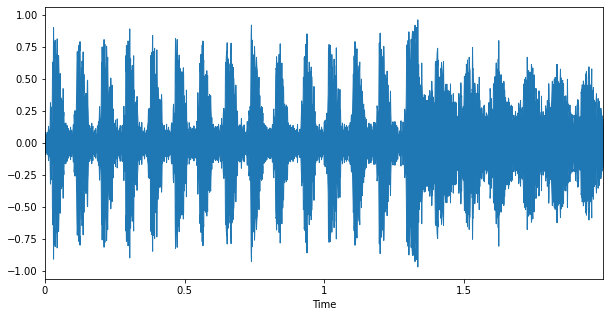

In [8]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=Fs)

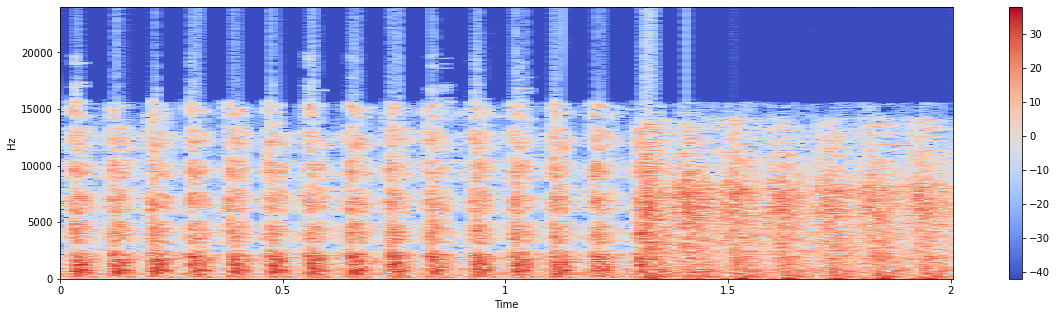

In [9]:
#display a spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=Fs, x_axis='time', y_axis='hz')
plt.colorbar()

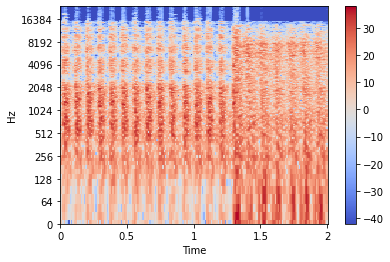

In [10]:
librosa.display.specshow(Xdb, sr=Fs, x_axis='time', y_axis='log')
plt.colorbar()

Time-domain audio features

In [11]:
def stZCR(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    countZ = numpy.sum(numpy.abs(numpy.diff(numpy.sign(frame)))) / 2
    return (numpy.float64(countZ) / numpy.float64(count-1.0))

In [12]:
def stEnergy(frame):
    """Computes signal energy of frame"""
    return numpy.sum(frame ** 2) / numpy.float64(len(frame))

In [13]:
energy = stEnergy(x)

In [14]:
energy

0.030928077697753905

In [15]:
eps = 0.00000001
def stEnergyEntropy(frame, numOfShortBlocks=10):
    """Computes entropy of energy"""
    Eol = numpy.sum(frame ** 2)    # total frame energy
    L = len(frame)
    subWinLength = int(numpy.floor(L / numOfShortBlocks))
    if L != subWinLength * numOfShortBlocks:
            frame = frame[0:subWinLength * numOfShortBlocks]
    # subWindows is of size [numOfShortBlocks x L]
    subWindows = frame.reshape(subWinLength, numOfShortBlocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -numpy.sum(s * numpy.log2(s + eps))
    return Entropy

In [16]:
energy1 = stEnergyEntropy(x)

In [17]:
energy1

3.296798

Frequency-domain audio features

In [18]:
def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (numpy.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = numpy.sum(ind * Xt)
    DEN = numpy.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = numpy.sqrt(numpy.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)

In [19]:
def stSpectralEntropy(X, numOfShortBlocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = numpy.sum(X ** 2)            # total spectral energy

    subWinLength = int(numpy.floor(L / numOfShortBlocks))   # length of sub-frame
    if L != subWinLength * numOfShortBlocks:
        X = X[0:subWinLength * numOfShortBlocks]

    subWindows = X.reshape(subWinLength, numOfShortBlocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -numpy.sum(s*numpy.log2(s + eps))                                    # compute spectral entropy

    return En

In [20]:
def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = numpy.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position where the respective spectral energy is equal to c*totalEnergy
    CumSum = numpy.cumsum(X ** 2) + eps
    [a, ] = numpy.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = numpy.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)

In [21]:
SpectralEntropy =stSpectralEntropy(x)

In [22]:
SpectralEntropy

3.296798

In [23]:
def stSpectralFlux(X, Xprev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:        the abs(fft) of the current frame
        Xpre:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = numpy.sum(X + eps)
    sumPrevX = numpy.sum(Xprev + eps)
    F = numpy.sum((X / sumX - Xprev/sumPrevX) ** 2)

    return F

In [24]:
def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt

    # Compute frequency points of the triangle:
    freqs = numpy.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + numpy.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** numpy.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = numpy.zeros((nFiltTotal, nfft))
    nfreqs = numpy.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = numpy.arange(numpy.floor(lowTrFreq * nfft / fs) + 1, numpy.floor(cenTrFreq * nfft / fs) + 1, dtype=numpy.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = numpy.arange(numpy.floor(cenTrFreq * nfft / fs) + 1, numpy.floor(highTrFreq * nfft / fs) + 1, dtype=numpy.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs

In [25]:
def stMFCC(X, fbank, nceps):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = numpy.log10(numpy.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:nceps]
    return ceps

In [26]:
path='C:/Users/ASUS/Desktop/glass'
#[Fs, x] =readAudioFile(path)
frameSize = 0.250
frameStep = 0.075
discard = 21

In [27]:
import mutagen
from mutagen.wave import WAVE
  
# function to convert the information into 
# some readable format
def audio_duration(length):
    hours = length // 3600  # calculate in hours
    length %= 3600
    mins = length // 60  # calculate in minutes
    length %= 60
    seconds = length  # calculate in seconds
  
    return hours, mins, seconds  # returns the duration
  
# Create a WAVE object
# Specify the directory address of your wavpack file
# "alarm.wav" is the name of the audiofile
audio = WAVE("C:/Users/ASUS/Desktop/glass/128A.wav")
  
# contains all the metadata about the wavpack file
audio_info = audio.info
length = int(audio_info.length)
hours, mins, seconds = audio_duration(length)
print('Total Duration: {}:{}:{}'.format(hours, mins, seconds))

Total Duration: 0:0:4


In [28]:
def stFeatureExtraction(signal, Fs, Win, Step):
    Win = int(Win)
    Step = int(Step)

    # Signal normalization
    signal = numpy.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX + 0.0000000001)

    N = len(signal)                                # total number of samples
    curPos = 0
    countFrames = 0
    nFFT = int(Win / 2)

    [fbank, freqs] = mfccInitFilterBanks(Fs, nFFT)                # compute the triangular filter banks used in the mfcc calculation

    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 0
    nceps = 13
    numOfChromaFeatures = 13
    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures + numOfChromaFeatures

    i =0 
    stFeatures = []
    #stfeat ={}
    #finalfeat=[]
    while (curPos + Win - 1 < N):                        # for each short-term window until the end of signal
        countFrames += 1
        i = i+1
        #print(i)
        x = signal[curPos:curPos+Win]                    # get current window
        curPos = curPos + Step                           # update window position
        X = abs(fft(x))                                  # get fft magnitude
        X = X[0:nFFT]                                    # normalize fft
        X = X / len(X)
        if countFrames == 1:
            Xprev = X.copy()                             # keep previous fft mag (used in spectral flux)
        curFV = numpy.zeros((totalNumOfFeatures, 1))
        curFV[0] = stZCR(x)                              # zero crossing rate
        #stfeat["zero-crossing"] =stZCR(x) 
        curFV[1] = stEnergy(x)                           # short-term energy
        #stfeat["short-term-energy"] = stEnergy(x)
        curFV[2] = stEnergyEntropy(x)                    # short-term entropy of energy
        #stfeat["short-term-entropy"] =stEnergyEntropy(x) 
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, Fs)    # spectral centroid and spread
        #stfeat["spectral-centroid"] = stSpectralCentroidAndSpread(X, Fs)
        curFV[5] = stSpectralEntropy(X)                  # spectral entropy
        #stfeat["spectral-entropy"] = stSpectralEntropy(X) 
        curFV[6] = stSpectralFlux(X, Xprev)              # spectral flux
        #stfeat["spectral-flux"] = stSpectralFlux(X, Xprev)
        curFV[7] = stSpectralRollOff(X, 0.90, Fs)        # spectral rolloff
        #stfeat["spectral-rolloff"] = stSpectralRollOff(X, 0.90, Fs)
        curFV[numOfTimeSpectralFeatures:numOfTimeSpectralFeatures+nceps, 0] = stMFCC(X, fbank, nceps).copy()    # MFCCs
        #stfeat["MFCCs"] = stMFCC(X, fbank, nceps).copy()

        stFeatures.append(curFV)
        #finalfeat.append(stfeat)

        Xprev = X.copy()

    stFeatures = numpy.concatenate(stFeatures, 1)
    return stFeatures

In [29]:
 F =stFeatureExtraction(x,Fs,frameSize * Fs,frameStep * Fs)

In [30]:
raw_feature = F[:discard, :].T

In [32]:
F

array([[ 1.36511376e-01,  1.34261188e-01,  1.32094341e-01,
         1.37594800e-01,  1.39594966e-01,  1.40095008e-01,
         1.42345195e-01,  1.40261688e-01,  1.35427952e-01,
         1.34344529e-01,  1.28010668e-01,  1.28094008e-01,
         1.30427536e-01,  1.29010751e-01,  1.28594050e-01,
         1.46845570e-01,  1.75431286e-01,  2.03600300e-01,
         2.06933911e-01,  2.00933411e-01,  2.04850404e-01,
         2.07267272e-01,  1.96766397e-01,  1.91849321e-01],
       [ 3.76611100e-02,  3.60860545e-02,  3.45152434e-02,
         2.99654009e-02,  2.90760561e-02,  3.35037117e-02,
         3.63039456e-02,  3.79869158e-02,  3.51545169e-02,
         2.56425452e-02,  2.85724112e-02,  3.41536532e-02,
         3.62991578e-02,  3.39304969e-02,  2.81006719e-02,
         4.04495067e-02,  4.81417616e-02,  4.78227659e-02,
         3.06157071e-02,  2.81941470e-02,  2.90821269e-02,
         2.42409966e-02,  2.34359553e-02,  2.80273426e-02],
       [ 2.64231458e+00,  2.73508826e+00,  2.61278322e

In [33]:
raw_feature.shape

(24, 21)

In [34]:
raw_feature

array([[ 1.36511376e-01,  3.76611100e-02,  2.64231458e+00,
         1.94874058e-01,  1.75392399e-01,  1.21952912e+00,
         0.00000000e+00,  2.65500000e-01, -1.95625240e+01,
         2.94905628e-01, -1.39050035e+00,  1.23401170e-01,
        -6.07649784e-01,  3.02039525e-01, -1.68210432e-01,
        -2.63800113e-01, -1.83558275e-01, -1.79952572e-03,
         7.72186117e-03, -1.09928683e-01,  2.18865208e-01],
       [ 1.34261188e-01,  3.60860545e-02,  2.73508826e+00,
         1.91578020e-01,  1.72413685e-01,  1.21998669e+00,
         1.39005120e-04,  2.73500000e-01, -1.95270545e+01,
         2.22813242e-01, -1.28146180e+00,  1.37245871e-01,
        -6.37594801e-01,  2.86282266e-01, -1.38108655e-01,
        -2.31138162e-01, -1.85853816e-01, -8.13976699e-02,
        -4.31338522e-02, -2.32106657e-01,  2.04786450e-01],
       [ 1.32094341e-01,  3.45152434e-02,  2.61278322e+00,
         1.94854028e-01,  1.76844930e-01,  1.24522091e+00,
         1.22023244e-04,  2.74500000e-01, -1.95594186e

In [35]:
raw_feature[0].shape

(21,)

In [ ]:
#zero-crossing': 0.1918493207767314,
 # 'short-term-energy': 0.028027342603390012,
  #'short-term-entropy': 3.121505617131622,
  #'spectral-centroid': (0.20533957053569168, 0.15103664069089592),
  #'spectral-entropy': 1.8576007873027285,
  #'spectral-flux': 0.00010886302128553366,
  #'spectral-rolloff': 0.32133333333333336,
  #'MFCCs': array([-2.01513925e+01,  9.87275490e-01,  6.40441319e-02, -3.88703064e-02,
   #      -7.93401608e-02,  1.86562346e-01, -1.59876374e-01,  3.42980402e-02,
    #      7.50663417e-02, -7.40727517e-02,  5.85570966e-02,  6.98818323e-03,
     #     4.28122005e-02])},

In [47]:
def getFeature(signal, Fs, Win, Step):
    #featurefinall =[]
    F =stFeatureExtraction(signal,Fs,Win,Step)
    raw_feature = F[:discard, :].T
    feature = []
    tmp = []
    for j in range(0, raw_feature.shape[1]):  # compute median and med for each columns
        feature_column = raw_feature[:, j]
        median = numpy.median(raw_feature[:, j])
        median_absolute_deviation = numpy.median(numpy.abs(feature_column - median))
        tmp.append(median)
        tmp.append(median_absolute_deviation)
        
    feature.append(tmp)
    i =0
    feature1={}
    #feature1[new_f]=xx
    for x in feature:
        feature1['zero-crossing-median']=x[0]
        feature1['short-term-energy-median']=x[1]
        feature1['short-term-entropy-median']=x[2]
        feature1['spectral-centroid1-median']=x[3]
        feature1['spectral-centroid2-median']=x[4]
        feature1['spectral-entropy-median']=x[5]
        feature1['spectral-flux-median']=x[6]
        feature1['spectral-rolloff-median']=x[7]
        feature1['MFCCs1-median']=x[8]
        feature1['MFCCs2-median']=x[9]
        feature1['MFCCs3-median']=x[10]
        feature1['MFCCs4-median']=x[11]
        feature1['MFCCs5-median']=x[12]
        feature1['MFCCs6-median']=x[13]
        feature1['MFCCs7-median']=x[14]
        feature1['MFCCs8-median']=x[15]
        feature1['MFCCs9-median']=x[16]
        feature1['MFCCs10-median']=x[17]
        feature1['MFCCs11-median']=x[18]
        feature1['MFCCs12-median']=x[19]
        feature1['MFCCs13-median']=x[20]
        feature1['zero-crossing-deviation']=x[21]
        feature1['short-term-energy-deviation']=x[22]
        feature1['short-term-entropy-deviation']=x[23]
        feature1['spectral-centroid1-deviation']=x[24]
        feature1['spectral-centroid2-deviation']=x[25]
        feature1['spectral-entropy-deviation']=x[26]
        feature1['spectral-flux-deviation']=x[27]
        feature1['spectral-rolloff-deviation']=x[28]
        feature1['MFCCs1-deviation']=x[29]
        feature1['MFCCs2-deviation']=x[30]
        feature1['MFCCs3-deviation']=x[31]
        feature1['MFCCs4-deviation']=x[32]
        feature1['MFCCs5-deviation']=x[33]
        feature1['MFCCs6-deviation']=x[34]
        feature1['MFCCs7-deviation']=x[35]
        feature1['MFCCs8-deviation']=x[36]
        feature1['MFCCs9-deviation']=x[37]
        feature1['MFCCs10-deviation']=x[38]
        feature1['MFCCs11-deviation']=x[39]
        feature1['MFCCs12-deviation']=x[40]
        feature1['MFCCs13-deviation']=x[41]
       # for xx in x:
      #      i =i+1
       #     n = "feature"
        #    new_f =n + str(i)
         #   feature1[new_f]=xx
    #featurefinall.append(feature1)
    return feature1

In [172]:
#F =stFeatureExtraction(x,Fs,frameSize * Fs,frameStep * Fs)
#raw_feature = F[:discard, :].T
feature = []
tmp = []
for j in range(0, raw_feature.shape[1]):  # compute median and med for each columns
        #print(j)
        feature_column = raw_feature[:, j]
        #print(feature_column)
        median = numpy.median(raw_feature[:, j])
        #print(median)
        median_absolute_deviation = numpy.median(numpy.abs(feature_column - median))
        #print(median_absolute_deviation)
        tmp.append(median)
        tmp.append(median_absolute_deviation)

In [55]:
df = pd.DataFrame()

In [56]:
df3 = pd.DataFrame()

In [57]:
import pandas as pd

sound = pd.read_csv('C:/Users/ASUS/Desktop/soundfinall.csv')

In [40]:
sound.head(10)

,filename,category
0,1-(21)B.wav,1
1,1-(22)B.wav,1
2,1-(23)B.wav,1
3,1-(24)B.wav,1
4,1-(25)B.wav,1
5,1-(26)B.wav,1
6,1-(27)B.wav,1
7,1-(28)B.wav,1
8,1-(29)B.wav,1
9,1-(30)B.wav,1


In [135]:
c1=0
c2=0
c3=0
for file in os.listdir():
    audio_path = f"{path}/{file}"
   # print(audio_path)
    #if file in sound.values:
        #cate = sound.loc[sound['filename'] == file]
        #print(file)
    if file.find("B") != -1:
        #print(file)
        #if file =="111A.wav":
        c2= c2+1
    if file.find("A") != -1:
        c1= c1+1
    
    if file.find("C") != -1:
        c3= c3+1
        #print(file)
       # print(cate['filename'])
        #c = int(cate['category'])
        #print(c)
        #if c == 0:
         #   print(file)
          #  c1= c1+1
       # elif c == 1:
         #   c2 =c2+1
        #else:
          #  c3= c3 +1

In [136]:
print(c1)
print(c2)
print(c3)

151
192
214


In [42]:
(sound["category"]==1).value_counts()

False    365
True     192
Name: category, dtype: int64

In [43]:
(sound["category"]==0).value_counts()

False    406
True     151
Name: category, dtype: int64

In [44]:
(sound["category"]==2).value_counts()

False    343
True     214
Name: category, dtype: int64

In [45]:
if '1-(21)B.wav' in sound.values:
    x= sound.loc[sound['filename'] == '1-(21)B.wav']

In [59]:
os.chdir(path)
i=0
for file in os.listdir():
    i = i+1
    audio_path = f"{path}/{file}"
    if file in sound.values:
        cate = sound.loc[sound['filename'] == file]
        x, Fs = librosa.load(audio_path,res_type='kaiser_fast',sr=None)
        F =getFeature(x,Fs,frameSize * Fs,frameStep * Fs)
        F['category'] = int(cate['category'])
        F['filename'] = file
        print(F)
        df2 = df.append(F, ignore_index = True)
        df3 = pd.concat([df2,df3],axis = 0)
        print("number",i)
        #print(i)

{'zero-crossing-median': 0.13984498708225684, 'short-term-energy-median': 0.01012584382031835, 'short-term-entropy-median': 0.033717104322162, 'spectral-centroid1-median': 0.004452394473410016, 'spectral-centroid2-median': 2.7259363546726814, 'spectral-entropy-median': 0.09927722713462117, 'spectral-flux-median': 0.19876683432759024, 'spectral-rolloff-median': 0.006355979762739869, 'MFCCs1-median': 0.1752599429175693, 'MFCCs2-median': 0.0028992793453324894, 'MFCCs3-median': 1.282967357691399, 'MFCCs4-median': 0.08078067848373016, 'MFCCs5-median': 0.00012536177302149842, 'MFCCs6-median': 1.706833702261616e-05, 'MFCCs7-median': 0.2788333333333334, 'MFCCs8-median': 0.018333333333333396, 'MFCCs9-median': -19.610095377529035, 'MFCCs10-median': 0.19302586482115025, 'MFCCs11-median': 0.4568353872612194, 'MFCCs12-median': 0.08660666262554753, 'MFCCs13-median': -1.140397199373795, 'zero-crossing-deviation': 0.14212063503351935, 'short-term-energy-deviation': 0.16641053766452055, 'short-term-ent

number 7
{'zero-crossing-median': 0.16934744562046838, 'short-term-energy-median': 0.002916909742478546, 'short-term-entropy-median': 0.032514595203354285, 'spectral-centroid1-median': 0.001477429606905896, 'spectral-centroid2-median': 2.812707565127161, 'spectral-entropy-median': 0.04725161912104725, 'spectral-flux-median': 0.2354506159157268, 'spectral-rolloff-median': 0.0051416465930526345, 'MFCCs1-median': 0.1743874957401213, 'MFCCs2-median': 0.002993895353592582, 'MFCCs3-median': 2.08417556633161, 'MFCCs4-median': 0.03661753875786444, 'MFCCs5-median': 0.00010034026407033754, 'MFCCs6-median': 8.523571617062548e-06, 'MFCCs7-median': 0.35716666666666663, 'MFCCs8-median': 0.007750000000000035, 'MFCCs9-median': -19.944614984526837, 'MFCCs10-median': 0.26208704270138483, 'MFCCs11-median': -0.08307416511905401, 'MFCCs12-median': 0.11442393769990555, 'MFCCs13-median': -0.2730895587724327, 'zero-crossing-deviation': 0.07007070772371381, 'short-term-energy-deviation': -0.23597019757418142, 

number 13
{'zero-crossing-median': 0.18172347695641305, 'short-term-energy-median': 0.009042420201683471, 'short-term-entropy-median': 0.06266309711532718, 'spectral-centroid1-median': 0.0035035585835092205, 'spectral-centroid2-median': 3.212365422493881, 'spectral-entropy-median': 0.03305617543519501, 'spectral-flux-median': 0.24142333807011634, 'spectral-rolloff-median': 0.005732615994920795, 'MFCCs1-median': 0.19341447952372265, 'MFCCs2-median': 0.001443298886677588, 'MFCCs3-median': 1.823803081518205, 'MFCCs4-median': 0.10203809803147912, 'MFCCs5-median': 0.0001128716116118689, 'MFCCs6-median': 1.0345132880296213e-05, 'MFCCs7-median': 0.34358333333333335, 'MFCCs8-median': 0.01908333333333337, 'MFCCs9-median': -19.05025306045284, 'MFCCs10-median': 0.09826886648332689, 'MFCCs11-median': -0.14171226385637453, 'MFCCs12-median': 0.05464837138150132, 'MFCCs13-median': -1.2953409344510358, 'zero-crossing-deviation': 0.04422245761050703, 'short-term-energy-deviation': -0.868268165236963, '

number 19
{'zero-crossing-median': 0.18468205683806982, 'short-term-energy-median': 0.001958496541378446, 'short-term-entropy-median': 0.04783969640090434, 'spectral-centroid1-median': 0.0034691645238802624, 'spectral-centroid2-median': 2.8602616332887534, 'spectral-entropy-median': 0.07282430670021545, 'spectral-flux-median': 0.23517888111788543, 'spectral-rolloff-median': 0.0022830581357845686, 'MFCCs1-median': 0.15715206132109566, 'MFCCs2-median': 0.0010082680816604211, 'MFCCs3-median': 2.20651113353353, 'MFCCs4-median': 0.0185136826356902, 'MFCCs5-median': 9.690856127326529e-05, 'MFCCs6-median': 4.983363416260453e-06, 'MFCCs7-median': 0.36666666666666664, 'MFCCs8-median': 0.00491666666666668, 'MFCCs9-median': -19.861555611612452, 'MFCCs10-median': 0.048955016207173685, 'MFCCs11-median': -0.054060226011064756, 'MFCCs12-median': 0.07257448225025243, 'MFCCs13-median': -0.0755055625327694, 'zero-crossing-deviation': 0.052231221206427425, 'short-term-energy-deviation': -0.34397220067020

number 25
{'zero-crossing-median': 0.1288857404783732, 'short-term-energy-median': 0.002625218768230686, 'short-term-entropy-median': 0.0719392141077563, 'spectral-centroid1-median': 0.002181531674878265, 'spectral-centroid2-median': 3.3112356857046255, 'spectral-entropy-median': 0.002600205734319072, 'spectral-flux-median': 0.1788447323349396, 'spectral-rolloff-median': 0.003111325543652649, 'MFCCs1-median': 0.154301051047721, 'MFCCs2-median': 0.002645576662625812, 'MFCCs3-median': 1.408668126162882, 'MFCCs4-median': 0.03023500150009173, 'MFCCs5-median': 0.0001363905497295624, 'MFCCs6-median': 9.110625073903498e-06, 'MFCCs7-median': 0.23025, 'MFCCs8-median': 0.004166666666666666, 'MFCCs9-median': -18.311675635849777, 'MFCCs10-median': 0.08924003571141625, 'MFCCs11-median': 0.6769201972592797, 'MFCCs12-median': 0.040038957372922956, 'MFCCs13-median': -0.6626521280157978, 'zero-crossing-deviation': 0.024810322251106354, 'short-term-energy-deviation': -0.34916915684357214, 'short-term-en

{'zero-crossing-median': 0.0390032502708559, 'short-term-energy-median': 0.0012917743145262096, 'short-term-entropy-median': 0.14294248991763542, 'spectral-centroid1-median': 0.004987756538179025, 'spectral-centroid2-median': 3.222591957866784, 'spectral-entropy-median': 0.011362564256447216, 'spectral-flux-median': 0.11260050839864658, 'spectral-rolloff-median': 0.0030122133644656865, 'MFCCs1-median': 0.1571061481508239, 'MFCCs2-median': 0.005064861759181458, 'MFCCs3-median': 0.19807110296785932, 'MFCCs4-median': 0.0115546957867102, 'MFCCs5-median': 0.0003958825765637182, 'MFCCs6-median': 4.521350788107235e-05, 'MFCCs7-median': 0.041499999999999995, 'MFCCs8-median': 0.0014166666666666598, 'MFCCs9-median': -17.66218369477847, 'MFCCs10-median': 0.0496254207266702, 'MFCCs11-median': 2.6118558829415948, 'MFCCs12-median': 0.042589263267009514, 'MFCCs13-median': -0.6537545962043476, 'zero-crossing-deviation': 0.04499084347151988, 'short-term-energy-deviation': 0.10907452538822904, 'short-te

number 38
{'zero-crossing-median': 0.0753356313497823, 'short-term-energy-median': 0.021498548621190137, 'short-term-entropy-median': 0.0006559377202542192, 'spectral-centroid1-median': 0.0006112228801201309, 'spectral-centroid2-median': 3.1020676378999696, 'spectral-entropy-median': 0.12379803332799488, 'spectral-flux-median': 0.10301507290362052, 'spectral-rolloff-median': 0.015431433384825347, 'MFCCs1-median': 0.10900654212765777, 'MFCCs2-median': 0.013622699855192565, 'MFCCs3-median': 0.8128203679267115, 'MFCCs4-median': 0.3670511139503153, 'MFCCs5-median': 0.0003159827720008566, 'MFCCs6-median': 0.00011792843650958197, 'MFCCs7-median': 0.11973875181422351, 'MFCCs8-median': 0.02567126269956458, 'MFCCs9-median': -24.29545547514981, 'MFCCs10-median': 2.9851176951128675, 'MFCCs11-median': 0.6381436470968875, 'MFCCs12-median': 0.24074649803663528, 'MFCCs13-median': -0.26248544934044143, 'zero-crossing-deviation': 0.19430701180144133, 'short-term-energy-deviation': 0.173381242379031, 's

number 44
{'zero-crossing-median': 0.09923802612481858, 'short-term-energy-median': 0.0053066037735849045, 'short-term-entropy-median': 0.008317930748698243, 'spectral-centroid1-median': 0.006541737078551593, 'spectral-centroid2-median': 2.9407874361835855, 'spectral-entropy-median': 0.2540747783571502, 'spectral-flux-median': 0.12087394032607855, 'spectral-rolloff-median': 0.005711639680222737, 'MFCCs1-median': 0.10345290819770242, 'MFCCs2-median': 0.012070115957459618, 'MFCCs3-median': 1.1746388338538667, 'MFCCs4-median': 0.06256448830647832, 'MFCCs5-median': 0.00023302025339491965, 'MFCCs6-median': 9.775931582371459e-05, 'MFCCs7-median': 0.15212264150943394, 'MFCCs8-median': 0.015602322206095767, 'MFCCs9-median': -21.023227457607362, 'MFCCs10-median': 1.2796765442022071, 'MFCCs11-median': 0.2814893135825438, 'MFCCs12-median': 0.17765056845675378, 'MFCCs13-median': 0.028786627733690864, 'zero-crossing-deviation': 0.15476416137900617, 'short-term-energy-deviation': 0.20812881311820494

number 50
{'zero-crossing-median': 0.102322206095791, 'short-term-energy-median': 0.012155297532656019, 'short-term-entropy-median': 0.011056547327315975, 'spectral-centroid1-median': 0.010397786852954637, 'spectral-centroid2-median': 3.01846409104136, 'spectral-entropy-median': 0.24987967826126734, 'spectral-flux-median': 0.13225432710583912, 'spectral-rolloff-median': 0.024097199805711206, 'MFCCs1-median': 0.12319488965315523, 'MFCCs2-median': 0.01940612842319181, 'MFCCs3-median': 1.2518095890588428, 'MFCCs4-median': 0.26182037309230854, 'MFCCs5-median': 0.0002717503886124216, 'MFCCs6-median': 5.21633558868951e-05, 'MFCCs7-median': 0.17144412191582004, 'MFCCs8-median': 0.04199927431059505, 'MFCCs9-median': -21.094298898801117, 'MFCCs10-median': 1.773928656129371, 'MFCCs11-median': 0.12010715166759035, 'MFCCs12-median': 0.20936099435864025, 'MFCCs13-median': -0.0672452882738996, 'zero-crossing-deviation': 0.19210327722190823, 'short-term-energy-deviation': 0.20900586632536733, 'short-

{'zero-crossing-median': 0.04068396226415094, 'short-term-energy-median': 0.013243831640058053, 'short-term-entropy-median': 0.004856873363005759, 'spectral-centroid1-median': 0.004818785177090677, 'spectral-centroid2-median': 2.9777409852285484, 'spectral-entropy-median': 0.28985105189569893, 'spectral-flux-median': 0.12878456544032596, 'spectral-rolloff-median': 0.036717325275607955, 'MFCCs1-median': 0.1495756544594209, 'MFCCs2-median': 0.03483035949516721, 'MFCCs3-median': 0.25959536463201616, 'MFCCs4-median': 0.21218981402318138, 'MFCCs5-median': 0.000757308765398423, 'MFCCs6-median': 0.0005875363984168579, 'MFCCs7-median': 0.08018867924528301, 'MFCCs8-median': 0.05959724238026125, 'MFCCs9-median': -22.751267383655318, 'MFCCs10-median': 2.207544376224787, 'MFCCs11-median': 0.9025296525288352, 'MFCCs12-median': 1.3028814236722366, 'MFCCs13-median': -0.21543998348117807, 'zero-crossing-deviation': 0.3876060784268188, 'short-term-energy-deviation': -0.09404758997950802, 'short-term-en

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 3.013619685327779e-09, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.320510101387511, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941951978, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.1918034816047526e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.47631777976129636, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 1.1603686709260913e-15, 'MFCCs12-median': 0.0, 'MFCCs13-median': 3.8413740218132775e-16, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 9.757220228824086e-16, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 1.1286225034818677e-17, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 6.650431759306793e-16, 'spectral-flux-deviation': 0.0, 'spectral-ro

number 69
{'zero-crossing-median': 0.18443203600300026, 'short-term-energy-median': 0.0566713892824402, 'short-term-entropy-median': 1.3203238772265185e-07, 'spectral-centroid1-median': 1.2210762957370333e-07, 'spectral-centroid2-median': 2.5104465957622257, 'spectral-entropy-median': 0.6801643626034313, 'spectral-flux-median': 0.37063922782657815, 'spectral-rolloff-median': 0.014651372678494479, 'MFCCs1-median': 0.24424055844849404, 'MFCCs2-median': 0.022021228617697203, 'MFCCs3-median': 1.9867207643285103, 'MFCCs4-median': 0.42138379883259125, 'MFCCs5-median': 0.00011501224291665092, 'MFCCs6-median': 4.920469997382166e-05, 'MFCCs7-median': 0.4036666666666667, 'MFCCs8-median': 0.0718333333333333, 'MFCCs9-median': -39.439021033449656, 'MFCCs10-median': 3.2840622808827717, 'MFCCs11-median': 0.3182984769695658, 'MFCCs12-median': 0.6278380212472316, 'MFCCs13-median': 0.11867297166366661, 'zero-crossing-deviation': 0.14169466682884338, 'short-term-energy-deviation': 0.49055245718431856, 's

number 76
{'zero-crossing-median': 0.22342162554426706, 'short-term-energy-median': 0.010794629898403463, 'short-term-entropy-median': 0.005719699084494605, 'spectral-centroid1-median': 0.0057065883277174, 'spectral-centroid2-median': 3.064559543722657, 'spectral-entropy-median': 0.14490915185243702, 'spectral-flux-median': 0.21936121767307468, 'spectral-rolloff-median': 0.0043487048099378756, 'MFCCs1-median': 0.09418358470702637, 'MFCCs2-median': 0.0075288910136394604, 'MFCCs3-median': 1.4495634968402087, 'MFCCs4-median': 0.059251590184352665, 'MFCCs5-median': 0.0003726437000277565, 'MFCCs6-median': 0.0001460124966001565, 'MFCCs7-median': 0.30007256894049344, 'MFCCs8-median': 0.002358490566037763, 'MFCCs9-median': -27.085160389269113, 'MFCCs10-median': 2.641574178855894, 'MFCCs11-median': -1.2629139113247718, 'MFCCs12-median': 0.40408932804401676, 'MFCCs13-median': 0.33709995778455293, 'zero-crossing-deviation': 0.27064202089923095, 'short-term-energy-deviation': 0.04578206771624062, 

{'zero-crossing-median': 0.31041364296081275, 'short-term-energy-median': 0.010613207547169767, 'short-term-entropy-median': 0.001161258697403082, 'spectral-centroid1-median': 0.0011612584366975291, 'spectral-centroid2-median': 3.10860988553679, 'spectral-entropy-median': 0.19788753623598732, 'spectral-flux-median': 0.34418198019050084, 'spectral-rolloff-median': 0.021206720318304007, 'MFCCs1-median': 0.2187083101932554, 'MFCCs2-median': 0.009790137449965014, 'MFCCs3-median': 2.5006591294912117, 'MFCCs4-median': 0.2642661446921486, 'MFCCs5-median': 0.00013189578485033537, 'MFCCs6-median': 4.466395413567943e-05, 'MFCCs7-median': 0.44575471698113206, 'MFCCs8-median': 0.12010159651669083, 'MFCCs9-median': -26.367089981397953, 'MFCCs10-median': 2.605701420172622, 'MFCCs11-median': -0.666947718662011, 'MFCCs12-median': 0.33386005083124926, 'MFCCs13-median': 0.2950376231165641, 'zero-crossing-deviation': 0.08063249291566255, 'short-term-energy-deviation': 0.5652338940124055, 'short-term-entr

{'zero-crossing-median': 0.1326777231435953, 'short-term-energy-median': 0.06583881990165846, 'short-term-entropy-median': 1.4611332567449632e-06, 'spectral-centroid1-median': 1.450668634368412e-06, 'spectral-centroid2-median': 2.668648676362006, 'spectral-entropy-median': 0.3884093070515564, 'spectral-flux-median': 0.2638269101940854, 'spectral-rolloff-median': 0.013470882208057089, 'MFCCs1-median': 0.18009846593100637, 'MFCCs2-median': 0.008754809704573624, 'MFCCs3-median': 1.784833294018783, 'MFCCs4-median': 0.405521532676167, 'MFCCs5-median': 0.00018914904522936, 'MFCCs6-median': 0.00012236869029540662, 'MFCCs7-median': 0.30083333333333334, 'MFCCs8-median': 0.058499999999999996, 'MFCCs9-median': -36.008301990089656, 'MFCCs10-median': 7.648607392140349, 'MFCCs11-median': -0.38850028001017856, 'MFCCs12-median': 0.47818874851083315, 'MFCCs13-median': -0.41000024508342114, 'zero-crossing-deviation': 0.4073412037574403, 'short-term-energy-deviation': -0.08411803498597745, 'short-term-en

{'zero-crossing-median': 0.2038086507208934, 'short-term-energy-median': 0.05108759063255272, 'short-term-entropy-median': 1.0997706088828834e-05, 'spectral-centroid1-median': 1.094260240071315e-05, 'spectral-centroid2-median': 3.0600463205111836, 'spectral-entropy-median': 0.10963011781841048, 'spectral-flux-median': 0.25695924222398614, 'spectral-rolloff-median': 0.03445409918766519, 'MFCCs1-median': 0.194018513652998, 'MFCCs2-median': 0.007289275922278696, 'MFCCs3-median': 2.1644148093445104, 'MFCCs4-median': 0.28786722013593047, 'MFCCs5-median': 0.00010321694856575998, 'MFCCs6-median': 2.3350581662612368e-05, 'MFCCs7-median': 0.3724166666666666, 'MFCCs8-median': 0.05550000000000005, 'MFCCs9-median': -31.416063983037482, 'MFCCs10-median': 5.348392311648809, 'MFCCs11-median': -0.2847935739252899, 'MFCCs12-median': 0.6251890172317109, 'MFCCs13-median': -0.2347488969131617, 'zero-crossing-deviation': 0.11138930375559342, 'short-term-energy-deviation': 0.013279989762054745, 'short-term-

{'zero-crossing-median': 0.017189767779390422, 'short-term-energy-median': 0.008345428156748913, 'short-term-entropy-median': 0.01027529984533885, 'spectral-centroid1-median': 0.0024612230655449013, 'spectral-centroid2-median': 3.0785385084170596, 'spectral-entropy-median': 0.0613836376162864, 'spectral-flux-median': 0.14873382453613626, 'spectral-rolloff-median': 0.05461514370567748, 'MFCCs1-median': 0.19355483657237454, 'MFCCs2-median': 0.0164405939501181, 'MFCCs3-median': 0.22217121545909668, 'MFCCs4-median': 0.1862105812903721, 'MFCCs5-median': 0.0018402207760670286, 'MFCCs6-median': 0.0013309533297922657, 'MFCCs7-median': 0.0047169811320754715, 'MFCCs8-median': 0.000544267053701016, 'MFCCs9-median': -25.29897157354132, 'MFCCs10-median': 0.7309309055400348, 'MFCCs11-median': 1.1475622942224355, 'MFCCs12-median': 0.718804599765972, 'MFCCs13-median': 0.9567210489872748, 'zero-crossing-deviation': 0.16654750886320807, 'short-term-energy-deviation': 0.5586485823822672, 'short-term-entr

{'zero-crossing-median': 0.11660921625544268, 'short-term-energy-median': 0.0058055152394774975, 'short-term-entropy-median': 0.05558978095851311, 'spectral-centroid1-median': 0.0020766796484145873, 'spectral-centroid2-median': 2.621010554721493, 'spectral-entropy-median': 0.05334734677454289, 'spectral-flux-median': 0.22004370969044604, 'spectral-rolloff-median': 0.005171180852799592, 'MFCCs1-median': 0.1954654587471541, 'MFCCs2-median': 0.000783315521906594, 'MFCCs3-median': 1.404340792157521, 'MFCCs4-median': 0.10644044028791544, 'MFCCs5-median': 0.0001347684748649172, 'MFCCs6-median': 4.388853253344906e-05, 'MFCCs7-median': 0.2984397677793904, 'MFCCs8-median': 0.024219883889695204, 'MFCCs9-median': -18.537980847596266, 'MFCCs10-median': 0.06585226374990683, 'MFCCs11-median': 1.227434509217722, 'MFCCs12-median': 0.0439124044744551, 'MFCCs13-median': -0.5938061237370098, 'zero-crossing-deviation': 0.04773576737222507, 'short-term-energy-deviation': -0.46314188364442643, 'short-term-e

{'zero-crossing-median': 0.11207365747460087, 'short-term-energy-median': 0.014150943396226426, 'short-term-entropy-median': 0.06268107132789845, 'spectral-centroid1-median': 0.015233356304259447, 'spectral-centroid2-median': 2.640376608498797, 'spectral-entropy-median': 0.2690331617246955, 'spectral-flux-median': 0.2268130443039585, 'spectral-rolloff-median': 0.005133503586423532, 'MFCCs1-median': 0.1960289448579053, 'MFCCs2-median': 0.002886980574264439, 'MFCCs3-median': 1.4416799420214668, 'MFCCs4-median': 0.09120923502103684, 'MFCCs5-median': 0.0001112718833132147, 'MFCCs6-median': 7.684740148631067e-05, 'MFCCs7-median': 0.3265602322206096, 'MFCCs8-median': 0.024129172714078384, 'MFCCs9-median': -18.459024979284088, 'MFCCs10-median': 0.3613593414738929, 'MFCCs11-median': 1.1952138361901155, 'MFCCs12-median': 0.10435204519569763, 'MFCCs13-median': -0.6307954731475581, 'zero-crossing-deviation': 0.13187227762847065, 'short-term-energy-deviation': -0.4028468204300634, 'short-term-entr

{'zero-crossing-median': 0.08390783744557329, 'short-term-energy-median': 0.015466255442670523, 'short-term-entropy-median': 3.5576715322520306e-05, 'spectral-centroid1-median': 2.4136081137758622e-05, 'spectral-centroid2-median': 2.9427153309062857, 'spectral-entropy-median': 0.16289628713409732, 'spectral-flux-median': 0.28732548784854284, 'spectral-rolloff-median': 0.029082813841003807, 'MFCCs1-median': 0.25753033025628247, 'MFCCs2-median': 0.00926504730058944, 'MFCCs3-median': 0.5349902865217577, 'MFCCs4-median': 0.13294049383614187, 'MFCCs5-median': 0.0007138185164724047, 'MFCCs6-median': 0.00030683998596364465, 'MFCCs7-median': 0.0975145137880987, 'MFCCs8-median': 0.01288098693759071, 'MFCCs9-median': -33.25193038008238, 'MFCCs10-median': 0.5575614031290144, 'MFCCs11-median': 0.5420450565049595, 'MFCCs12-median': 0.6684292873274461, 'MFCCs13-median': 0.2734243468862008, 'zero-crossing-deviation': 0.08785363812041924, 'short-term-energy-deviation': 0.3232803651056834, 'short-term-

number 125
{'zero-crossing-median': 0.5716878402903811, 'short-term-energy-median': 0.005081669691470059, 'short-term-entropy-median': 0.046282184723452434, 'spectral-centroid1-median': 0.001004699097052128, 'spectral-centroid2-median': 3.2469020022153714, 'spectral-entropy-median': 0.025747337942593873, 'spectral-flux-median': 0.5393302599906122, 'spectral-rolloff-median': 0.012942014957293524, 'MFCCs1-median': 0.2906970365184868, 'MFCCs2-median': 0.005703878101123383, 'MFCCs3-median': 3.121101471830105, 'MFCCs4-median': 0.026038127669849143, 'MFCCs5-median': 0.00025071609166975583, 'MFCCs6-median': 6.340591323737753e-05, 'MFCCs7-median': 0.941944847605225, 'MFCCs8-median': 0.006531204644412147, 'MFCCs9-median': -19.7719970755716, 'MFCCs10-median': 0.30167718795127385, 'MFCCs11-median': -0.038525646387510326, 'MFCCs12-median': 0.12315909532882907, 'MFCCs13-median': 0.15489957074524208, 'zero-crossing-deviation': 0.06756683448176025, 'short-term-energy-deviation': 0.3994528474371645, '

number 131
{'zero-crossing-median': 0.4904735982580294, 'short-term-energy-median': 0.012883324260569762, 'short-term-entropy-median': 0.0011137780459489447, 'spectral-centroid1-median': 0.0008139840242654742, 'spectral-centroid2-median': 2.915152888647212, 'spectral-entropy-median': 0.2286901801977823, 'spectral-flux-median': 0.5169190448007938, 'spectral-rolloff-median': 0.014739115701534411, 'MFCCs1-median': 0.2624248613496879, 'MFCCs2-median': 0.006107258899733403, 'MFCCs3-median': 3.1561721664140214, 'MFCCs4-median': 0.052412982259405716, 'MFCCs5-median': 0.00016857631682858868, 'MFCCs6-median': 4.323029095430682e-05, 'MFCCs7-median': 0.840711175616836, 'MFCCs8-median': 0.03555878084179964, 'MFCCs9-median': -27.802301302042345, 'MFCCs10-median': 2.0206071018568217, 'MFCCs11-median': -0.7539003118983623, 'MFCCs12-median': 0.40822564435088315, 'MFCCs13-median': 0.9071176103016514, 'zero-crossing-deviation': 0.4370388708893722, 'short-term-energy-deviation': 0.1924495258752006, 'shor

{'zero-crossing-median': 0.6568058076225045, 'short-term-energy-median': 0.009074410163339375, 'short-term-entropy-median': 0.323386681947454, 'spectral-centroid1-median': 0.13889444018516928, 'spectral-centroid2-median': 3.2404302199912127, 'spectral-entropy-median': 0.0660877077041151, 'spectral-flux-median': 0.607516423918708, 'spectral-rolloff-median': 0.010154652063089076, 'MFCCs1-median': 0.26942916871763667, 'MFCCs2-median': 0.01321104984306018, 'MFCCs3-median': 2.841097624912411, 'MFCCs4-median': 0.1601899836401477, 'MFCCs5-median': 0.00027107479242384193, 'MFCCs6-median': 2.457112400913516e-05, 'MFCCs7-median': 0.9306966618287373, 'MFCCs8-median': 0.02503628447024675, 'MFCCs9-median': -18.576074391766994, 'MFCCs10-median': 1.040580304507504, 'MFCCs11-median': -0.7099240110655377, 'MFCCs12-median': 0.3348437447717328, 'MFCCs13-median': -0.0012744586224023476, 'zero-crossing-deviation': 0.10597989219052184, 'short-term-energy-deviation': -0.10728121280147038, 'short-term-entropy

number 144
{'zero-crossing-median': 0.3687171112320813, 'short-term-energy-median': 0.01778261658501179, 'short-term-entropy-median': 0.03209437364538508, 'spectral-centroid1-median': 0.005394315275277423, 'spectral-centroid2-median': 3.2762599161990864, 'spectral-entropy-median': 0.006546631228584676, 'spectral-flux-median': 0.41297138722575855, 'spectral-rolloff-median': 0.011461743430725202, 'MFCCs1-median': 0.263268157807042, 'MFCCs2-median': 0.0013931478812485576, 'MFCCs3-median': 2.8714069956397568, 'MFCCs4-median': 0.10676432710588202, 'MFCCs5-median': 0.00015013817301186692, 'MFCCs6-median': 1.337076317957378e-05, 'MFCCs7-median': 0.7119013062409288, 'MFCCs8-median': 0.044629898403483304, 'MFCCs9-median': -20.531634356318417, 'MFCCs10-median': 0.4419939664189201, 'MFCCs11-median': -0.043262510488838786, 'MFCCs12-median': 0.1397128812640198, 'MFCCs13-median': 0.027839156351212258, 'zero-crossing-deviation': 0.054371717608686476, 'short-term-energy-deviation': -0.0738414306934794

number 149
{'zero-crossing-median': 0.5833030852994555, 'short-term-energy-median': 0.025771324863883782, 'short-term-entropy-median': 0.027994466711786774, 'spectral-centroid1-median': 0.024271471452573582, 'spectral-centroid2-median': 3.1640627217456294, 'spectral-entropy-median': 0.07122973422887258, 'spectral-flux-median': 0.549580128442993, 'spectral-rolloff-median': 0.017625120798592353, 'MFCCs1-median': 0.28698712494847756, 'MFCCs2-median': 0.009358856969244211, 'MFCCs3-median': 3.1508098242861355, 'MFCCs4-median': 0.06842642931857634, 'MFCCs5-median': 0.00026409837756012546, 'MFCCs6-median': 5.395834113110313e-05, 'MFCCs7-median': 0.9179970972423802, 'MFCCs8-median': 0.005079825834542806, 'MFCCs9-median': -20.376036745241112, 'MFCCs10-median': 1.6282345275365735, 'MFCCs11-median': -0.3732988115414697, 'MFCCs12-median': 0.32767012624554726, 'MFCCs13-median': -0.06084763454009923, 'zero-crossing-deviation': 0.09702714324852543, 'short-term-energy-deviation': -0.022009595335853914

number 154
{'zero-crossing-median': 0.27581201233895847, 'short-term-energy-median': 0.05289421157684629, 'short-term-entropy-median': 0.01791132384526308, 'spectral-centroid1-median': 0.014811961676017702, 'spectral-centroid2-median': 2.7510437649908708, 'spectral-entropy-median': 0.06766497958997908, 'spectral-flux-median': 0.3376319921654896, 'spectral-rolloff-median': 0.026265320733387443, 'MFCCs1-median': 0.19550100762982653, 'MFCCs2-median': 0.007910917743151807, 'MFCCs3-median': 1.9408810494865536, 'MFCCs4-median': 0.1149151358680447, 'MFCCs5-median': 0.0008270871793213178, 'MFCCs6-median': 0.0005039312918162168, 'MFCCs7-median': 0.45718432510885343, 'MFCCs8-median': 0.018142235123367184, 'MFCCs9-median': -24.21629637707627, 'MFCCs10-median': 0.6981310685492019, 'MFCCs11-median': -1.9153734157444906, 'MFCCs12-median': 0.12495177435814209, 'MFCCs13-median': -1.045565539299547, 'zero-crossing-deviation': 0.1718898233457004, 'short-term-energy-deviation': 0.21973541251640155, 'shor

number 159
{'zero-crossing-median': 0.09869375907111756, 'short-term-energy-median': 0.009615384615384616, 'short-term-entropy-median': 0.056202672752039474, 'spectral-centroid1-median': 0.012387024636427567, 'spectral-centroid2-median': 2.5998538985928894, 'spectral-entropy-median': 0.13382074709451985, 'spectral-flux-median': 0.19861700542812505, 'spectral-rolloff-median': 0.005607047343554161, 'MFCCs1-median': 0.19204720740365488, 'MFCCs2-median': 0.005798366752107431, 'MFCCs3-median': 1.1646645985746473, 'MFCCs4-median': 0.06505304416436208, 'MFCCs5-median': 0.00015374546578700613, 'MFCCs6-median': 5.8393402987971973e-05, 'MFCCs7-median': 0.19312409288824384, 'MFCCs8-median': 0.022405660377358486, 'MFCCs9-median': -18.374796402936806, 'MFCCs10-median': 0.3086257092825644, 'MFCCs11-median': 1.1878677962848216, 'MFCCs12-median': 0.09092083260594208, 'MFCCs13-median': -0.5708837104146065, 'zero-crossing-deviation': 0.09454221535627849, 'short-term-energy-deviation': -0.293309020984174

{'zero-crossing-median': 0.04700391699308276, 'short-term-energy-median': 0.010334194516209688, 'short-term-entropy-median': 0.004884959595329114, 'spectral-centroid1-median': 0.003542429047384902, 'spectral-centroid2-median': 3.2425811565145355, 'spectral-entropy-median': 0.030248775076514356, 'spectral-flux-median': 0.10539146412915051, 'spectral-rolloff-median': 0.005840389058069634, 'MFCCs1-median': 0.1443968493873842, 'MFCCs2-median': 0.006088686923619233, 'MFCCs3-median': 0.3445170177057487, 'MFCCs4-median': 0.12538007703570297, 'MFCCs5-median': 0.00032708047432130824, 'MFCCs6-median': 8.386123583587328e-05, 'MFCCs7-median': 0.07008333333333333, 'MFCCs8-median': 0.03666666666666667, 'MFCCs9-median': -21.946055370377213, 'MFCCs10-median': 2.311966543725884, 'MFCCs11-median': 1.7748743228211827, 'MFCCs12-median': 0.5290743823484647, 'MFCCs13-median': 0.23963461689232635, 'zero-crossing-deviation': 0.19939775915612634, 'short-term-energy-deviation': 0.23889724125786838, 'short-term-

{'zero-crossing-median': 0.05767147262271856, 'short-term-energy-median': 0.02208517376448037, 'short-term-entropy-median': 0.07647387383354211, 'spectral-centroid1-median': 0.05466204686121132, 'spectral-centroid2-median': 3.1506243077281204, 'spectral-entropy-median': 0.14339967243722418, 'spectral-flux-median': 0.18484110290522168, 'spectral-rolloff-median': 0.014114731609731895, 'MFCCs1-median': 0.22596617489925136, 'MFCCs2-median': 0.005512334277492953, 'MFCCs3-median': 0.6566687808585703, 'MFCCs4-median': 0.09862952802207309, 'MFCCs5-median': 0.0003277487411879446, 'MFCCs6-median': 0.00013177061127923098, 'MFCCs7-median': 0.09883333333333333, 'MFCCs8-median': 0.02383333333333333, 'MFCCs9-median': -18.885839352626448, 'MFCCs10-median': 0.8200702141226586, 'MFCCs11-median': 1.656640125392323, 'MFCCs12-median': 0.3583351084517151, 'MFCCs13-median': 0.30766642995759974, 'zero-crossing-deviation': 0.06878585395297716, 'short-term-energy-deviation': 0.37559349826291266, 'short-term-ent

number 179
{'zero-crossing-median': 0.07175597966497207, 'short-term-energy-median': 0.0036669722476873057, 'short-term-entropy-median': 0.049777395475523886, 'spectral-centroid1-median': 0.01828385713879293, 'spectral-centroid2-median': 3.1390391413388006, 'spectral-entropy-median': 0.09459573036297719, 'spectral-flux-median': 0.1459719358747824, 'spectral-rolloff-median': 0.012858109888773103, 'MFCCs1-median': 0.1646567786864688, 'MFCCs2-median': 0.010952771980301035, 'MFCCs3-median': 0.7166303501493325, 'MFCCs4-median': 0.04114459077845234, 'MFCCs5-median': 0.00022891036728670764, 'MFCCs6-median': 3.749770492815893e-05, 'MFCCs7-median': 0.12583333333333335, 'MFCCs8-median': 0.010666666666666644, 'MFCCs9-median': -19.002753240125863, 'MFCCs10-median': 0.5193396411734348, 'MFCCs11-median': 1.5217837797939153, 'MFCCs12-median': 0.12442498910365307, 'MFCCs13-median': -0.28173684825986656, 'zero-crossing-deviation': 0.20597992173377389, 'short-term-energy-deviation': -0.06136518640405841

{'zero-crossing-median': 0.05571297608134011, 'short-term-energy-median': 0.003416951412617719, 'short-term-entropy-median': 0.03272139712323112, 'spectral-centroid1-median': 0.031174801021408592, 'spectral-centroid2-median': 3.021632984592995, 'spectral-entropy-median': 0.11414175301375229, 'spectral-flux-median': 0.1156422662171542, 'spectral-rolloff-median': 0.03181226800024163, 'MFCCs1-median': 0.14436296867776674, 'MFCCs2-median': 0.023252852785526253, 'MFCCs3-median': 0.5226671067118238, 'MFCCs4-median': 0.05659767518300535, 'MFCCs5-median': 0.0003773256769702871, 'MFCCs6-median': 0.00011717464051703454, 'MFCCs7-median': 0.08725, 'MFCCs8-median': 0.007666666666666662, 'MFCCs9-median': -19.388298721017946, 'MFCCs10-median': 1.39769157459353, 'MFCCs11-median': 1.469629667253931, 'MFCCs12-median': 0.08588709680373763, 'MFCCs13-median': 0.024463651988428765, 'zero-crossing-deviation': 0.12015956072922611, 'short-term-energy-deviation': 0.2735712772085118, 'short-term-entropy-deviatio

{'zero-crossing-median': 0.057546462205183765, 'short-term-energy-median': 0.032294357863155265, 'short-term-entropy-median': 0.02304460433228786, 'spectral-centroid1-median': 0.02221608665752829, 'spectral-centroid2-median': 3.0754309366484884, 'spectral-entropy-median': 0.08950411599485064, 'spectral-flux-median': 0.1569252260045653, 'spectral-rolloff-median': 0.03214126259799929, 'MFCCs1-median': 0.14737884451130212, 'MFCCs2-median': 0.018087352558603026, 'MFCCs3-median': 1.2292435030133142, 'MFCCs4-median': 0.19170572180635725, 'MFCCs5-median': 0.00023249636810001483, 'MFCCs6-median': 0.00016160945625491628, 'MFCCs7-median': 0.19216666666666668, 'MFCCs8-median': 0.028916666666666646, 'MFCCs9-median': -20.15949731816444, 'MFCCs10-median': 1.5777083269210515, 'MFCCs11-median': 1.0899227566864593, 'MFCCs12-median': 0.24732215331051033, 'MFCCs13-median': 0.10154174960148138, 'zero-crossing-deviation': 0.06496736244345132, 'short-term-energy-deviation': -0.01308328490064938, 'short-term

{'zero-crossing-median': 0.035544628719059924, 'short-term-energy-median': 0.02366863905325444, 'short-term-entropy-median': 0.010147619181221985, 'spectral-centroid1-median': 0.0033663633892495885, 'spectral-centroid2-median': 2.984192897564128, 'spectral-entropy-median': 0.15531647008157345, 'spectral-flux-median': 0.12471943774250058, 'spectral-rolloff-median': 0.01974633507748745, 'MFCCs1-median': 0.1573872608535618, 'MFCCs2-median': 0.028834382629600044, 'MFCCs3-median': 0.6143449776132961, 'MFCCs4-median': 0.3591688658087078, 'MFCCs5-median': 0.00040089207498462926, 'MFCCs6-median': 0.00022475985997709056, 'MFCCs7-median': 0.10258333333333333, 'MFCCs8-median': 0.07041666666666667, 'MFCCs9-median': -21.84785702620415, 'MFCCs10-median': 1.7600117989535136, 'MFCCs11-median': 1.292155258167025, 'MFCCs12-median': 0.5808728299253869, 'MFCCs13-median': -0.31983309930629433, 'zero-crossing-deviation': 0.23812654634785857, 'short-term-energy-deviation': 0.11782057182859748, 'short-term-en

{'zero-crossing-median': 0.07492291024252021, 'short-term-energy-median': 0.012334361196766393, 'short-term-entropy-median': 0.030087413247063967, 'spectral-centroid1-median': 0.014530645084899445, 'spectral-centroid2-median': 2.9556419075681952, 'spectral-entropy-median': 0.23192839913898844, 'spectral-flux-median': 0.15512468207955632, 'spectral-rolloff-median': 0.011848938447856103, 'MFCCs1-median': 0.1689392295776152, 'MFCCs2-median': 0.006971771026722182, 'MFCCs3-median': 0.7874036818805037, 'MFCCs4-median': 0.10349440769434842, 'MFCCs5-median': 0.0003183999728659369, 'MFCCs6-median': 0.00015775732593339758, 'MFCCs7-median': 0.13616666666666666, 'MFCCs8-median': 0.01433333333333335, 'MFCCs9-median': -20.04804610073866, 'MFCCs10-median': 0.6169777507300278, 'MFCCs11-median': 1.1216132396819796, 'MFCCs12-median': 0.05674530887490581, 'MFCCs13-median': 0.018026463325098628, 'zero-crossing-deviation': 0.09856215931600358, 'short-term-energy-deviation': 0.2261260142950541, 'short-term-

{'zero-crossing-median': 0.04533711142595216, 'short-term-energy-median': 0.009125760480040004, 'short-term-entropy-median': 0.0030050550450897995, 'spectral-centroid1-median': 0.002519462934828234, 'spectral-centroid2-median': 3.211744627801759, 'spectral-entropy-median': 0.08505690861880844, 'spectral-flux-median': 0.12622178121560604, 'spectral-rolloff-median': 0.03004563157347135, 'MFCCs1-median': 0.17655049265447834, 'MFCCs2-median': 0.02063939385857194, 'MFCCs3-median': 0.2431425441517458, 'MFCCs4-median': 0.0887247901571213, 'MFCCs5-median': 0.0006486254779144061, 'MFCCs6-median': 0.00018101826732880408, 'MFCCs7-median': 0.058083333333333334, 'MFCCs8-median': 0.003333333333333334, 'MFCCs9-median': -24.027237523287617, 'MFCCs10-median': 1.452991649056191, 'MFCCs11-median': 1.5963471721007263, 'MFCCs12-median': 0.2137435841627422, 'MFCCs13-median': 0.4792194327873953, 'zero-crossing-deviation': 0.32907947642084506, 'short-term-energy-deviation': 1.6975867676233036, 'short-term-ent

{'zero-crossing-median': 0.06971414284523711, 'short-term-energy-median': 0.006042170180848398, 'short-term-entropy-median': 0.04816396536596419, 'spectral-centroid1-median': 0.0114887644108688, 'spectral-centroid2-median': 3.258872616558475, 'spectral-entropy-median': 0.02369979987976678, 'spectral-flux-median': 0.14202584390506862, 'spectral-rolloff-median': 0.005616682887586141, 'MFCCs1-median': 0.16458991269593437, 'MFCCs2-median': 0.004786012648790763, 'MFCCs3-median': 0.6460335957910907, 'MFCCs4-median': 0.06202517140364139, 'MFCCs5-median': 0.0002557042680424907, 'MFCCs6-median': 2.564514926357847e-05, 'MFCCs7-median': 0.107, 'MFCCs8-median': 0.008416666666666663, 'MFCCs9-median': -19.056813008942207, 'MFCCs10-median': 0.30010725537882443, 'MFCCs11-median': 1.3308300904133938, 'MFCCs12-median': 0.11413668330377813, 'MFCCs13-median': 0.3261212058611809, 'zero-crossing-deviation': 0.05786100388141896, 'short-term-energy-deviation': 0.5027675311364392, 'short-term-entropy-deviation

{'zero-crossing-median': 0.05046253854487874, 'short-term-energy-median': 0.004125343778648219, 'short-term-entropy-median': 0.11893058146381559, 'spectral-centroid1-median': 0.026650451033307362, 'spectral-centroid2-median': 3.1792381402820586, 'spectral-entropy-median': 0.052946675172320434, 'spectral-flux-median': 0.18448269469469308, 'spectral-rolloff-median': 0.012356456609114955, 'MFCCs1-median': 0.2032929321135245, 'MFCCs2-median': 0.007874443475400617, 'MFCCs3-median': 0.663632786332853, 'MFCCs4-median': 0.14058937107799307, 'MFCCs5-median': 0.0003146027228360175, 'MFCCs6-median': 0.00017932286972933466, 'MFCCs7-median': 0.10400000000000001, 'MFCCs8-median': 0.02341666666666667, 'MFCCs9-median': -18.2495940221523, 'MFCCs10-median': 0.373888276745852, 'MFCCs11-median': 1.5183610242900043, 'MFCCs12-median': 0.10599750583647594, 'MFCCs13-median': -0.04394146249194375, 'zero-crossing-deviation': 0.061373033083941715, 'short-term-energy-deviation': 0.21173051528110848, 'short-term-e

number 227
{'zero-crossing-median': 0.04225352112676056, 'short-term-energy-median': 0.014501208434036171, 'short-term-entropy-median': 0.048997154617427915, 'spectral-centroid1-median': 0.011690229188667224, 'spectral-centroid2-median': 3.2164831663643065, 'spectral-entropy-median': 0.051437547792475335, 'spectral-flux-median': 0.13341528117841955, 'spectral-rolloff-median': 0.030736996043558826, 'MFCCs1-median': 0.16821578467645498, 'MFCCs2-median': 0.014115393891067446, 'MFCCs3-median': 0.4257616336572718, 'MFCCs4-median': 0.17940319946984096, 'MFCCs5-median': 0.00034188769981967365, 'MFCCs6-median': 0.00010040765680537216, 'MFCCs7-median': 0.06391666666666668, 'MFCCs8-median': 0.01958333333333332, 'MFCCs9-median': -19.408343995999523, 'MFCCs10-median': 0.38149626099802525, 'MFCCs11-median': 1.6243038460194403, 'MFCCs12-median': 0.0778863639410593, 'MFCCs13-median': 0.15907296888303502, 'zero-crossing-deviation': 0.053172158694372716, 'short-term-energy-deviation': 0.381952620115484

{'zero-crossing-median': 0.05796316359696642, 'short-term-energy-median': 0.013292774397866487, 'short-term-entropy-median': 0.0017275648501178982, 'spectral-centroid1-median': 0.0012348505428972118, 'spectral-centroid2-median': 3.055180856038932, 'spectral-entropy-median': 0.13833106991038813, 'spectral-flux-median': 0.1122508045166795, 'spectral-rolloff-median': 0.019118290023149312, 'MFCCs1-median': 0.14310790717366384, 'MFCCs2-median': 0.010496992442680708, 'MFCCs3-median': 0.45326626346863474, 'MFCCs4-median': 0.2691223885237938, 'MFCCs5-median': 0.0005178905341915713, 'MFCCs6-median': 0.00020997268426909028, 'MFCCs7-median': 0.07333333333333333, 'MFCCs8-median': 0.04616666666666667, 'MFCCs9-median': -24.491675898859782, 'MFCCs10-median': 2.5698855798451614, 'MFCCs11-median': 1.4289796632193696, 'MFCCs12-median': 0.21782343807158577, 'MFCCs13-median': 0.31616596607043895, 'zero-crossing-deviation': 0.08222433936834772, 'short-term-energy-deviation': 0.2519658809405306, 'short-term

number 239
{'zero-crossing-median': 0.05592132677723144, 'short-term-energy-median': 0.013542795232936077, 'short-term-entropy-median': 0.006921469032507266, 'spectral-centroid1-median': 0.0067820113187550025, 'spectral-centroid2-median': 2.9408281750068452, 'spectral-entropy-median': 0.13734945149600897, 'spectral-flux-median': 0.11164115386207275, 'spectral-rolloff-median': 0.011195826992883573, 'MFCCs1-median': 0.12117567022322973, 'MFCCs2-median': 0.010562102248667389, 'MFCCs3-median': 0.6445273996689846, 'MFCCs4-median': 0.13400149998858873, 'MFCCs5-median': 0.0003333709391249901, 'MFCCs6-median': 0.0001076876108788566, 'MFCCs7-median': 0.11291666666666667, 'MFCCs8-median': 0.01625, 'MFCCs9-median': -21.32967610274887, 'MFCCs10-median': 2.6356263751489415, 'MFCCs11-median': 1.052531893721859, 'MFCCs12-median': 0.41758397270763425, 'MFCCs13-median': 0.28500997907063397, 'zero-crossing-deviation': 0.2922298666181503, 'short-term-energy-deviation': 0.3288468532817061, 'short-term-ent

{'zero-crossing-median': 0.05837264150943396, 'short-term-energy-median': 0.0058055152394775045, 'short-term-entropy-median': 0.040973253625856486, 'spectral-centroid1-median': 0.02444951983271399, 'spectral-centroid2-median': 3.258178680476723, 'spectral-entropy-median': 0.024773264596140487, 'spectral-flux-median': 0.14084699131554176, 'spectral-rolloff-median': 0.022931109182837264, 'MFCCs1-median': 0.18011199345526926, 'MFCCs2-median': 0.03142918029162138, 'MFCCs3-median': 0.37439086785798736, 'MFCCs4-median': 0.05944274053367585, 'MFCCs5-median': 0.0003600237989134944, 'MFCCs6-median': 6.071095053029172e-05, 'MFCCs7-median': 0.08699201741654572, 'MFCCs8-median': 0.004989114658925979, 'MFCCs9-median': -19.125991028754864, 'MFCCs10-median': 0.7860313110807056, 'MFCCs11-median': 1.692342327145202, 'MFCCs12-median': 0.07426164628249632, 'MFCCs13-median': -0.1414204599145893, 'zero-crossing-deviation': 0.22712937389684282, 'short-term-energy-deviation': 0.227572831059354, 'short-term-e

{'zero-crossing-median': 0.1766600145137881, 'short-term-energy-median': 0.01855043541364297, 'short-term-entropy-median': 0.0010927439958192918, 'spectral-centroid1-median': 0.0010776847554005153, 'spectral-centroid2-median': 2.987926748701235, 'spectral-entropy-median': 0.28272591372778755, 'spectral-flux-median': 0.19211490003838255, 'spectral-rolloff-median': 0.020717638922435153, 'MFCCs1-median': 0.08263337892241435, 'MFCCs2-median': 0.011899027606443444, 'MFCCs3-median': 0.5745517793979245, 'MFCCs4-median': 0.29214259171510343, 'MFCCs5-median': 0.0006104019948210255, 'MFCCs6-median': 0.00021255832092251576, 'MFCCs7-median': 0.2016509433962264, 'MFCCs8-median': 0.02748548621190132, 'MFCCs9-median': -35.51737065038152, 'MFCCs10-median': 2.195201137272825, 'MFCCs11-median': -3.209506102497409, 'MFCCs12-median': 0.7669661078308643, 'MFCCs13-median': 1.466788154664305, 'zero-crossing-deviation': 0.18469040355289912, 'short-term-energy-deviation': -0.7493912739657135, 'short-term-entro

{'zero-crossing-median': 0.21185595065312046, 'short-term-energy-median': 0.050344702467343974, 'short-term-entropy-median': 8.58798350433085e-07, 'spectral-centroid1-median': 8.292238192522248e-07, 'spectral-centroid2-median': 2.1826719401665984, 'spectral-entropy-median': 0.9046479134498797, 'spectral-flux-median': 0.22791974283475858, 'spectral-rolloff-median': 0.027907426270255636, 'MFCCs1-median': 0.20043173309009737, 'MFCCs2-median': 0.038166079360936855, 'MFCCs3-median': 1.8058125691452407, 'MFCCs4-median': 0.3174051299130324, 'MFCCs5-median': 0.00012829605048339732, 'MFCCs6-median': 8.210229991002364e-05, 'MFCCs7-median': 0.3341799709724238, 'MFCCs8-median': 0.05506168359941946, 'MFCCs9-median': -34.51139172033743, 'MFCCs10-median': 4.680727338523681, 'MFCCs11-median': 0.21538497002494522, 'MFCCs12-median': 0.8139555901105252, 'MFCCs13-median': 0.13686719780243692, 'zero-crossing-deviation': 0.29269834522121774, 'short-term-energy-deviation': 0.4140745858998389, 'short-term-ent

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 9.9668066488229e-07, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.321073832328173, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941950677, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 5.599580896290867e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.0036045096192337594, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269404, 'MFCCs10-median': 0.0, 'MFCCs11-median': 2.5936607235866533e-14, 'MFCCs12-median': 0.0, 'MFCCs13-median': 1.5446774502765364e-14, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 1.2205646521913446e-14, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 9.719088262372933e-15, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 9.850986808062054e-15, 'spectral-flux-deviation': 0.0, 'spectral-rol

{'zero-crossing-median': 0.09220791001451378, 'short-term-energy-median': 0.016055878084179964, 'short-term-entropy-median': 0.0038210258498848036, 'spectral-centroid1-median': 0.0034468073604407177, 'spectral-centroid2-median': 1.1902949888396157, 'spectral-entropy-median': 0.17036479473980481, 'spectral-flux-median': 0.07660508524722932, 'spectral-rolloff-median': 0.0121775965752065, 'MFCCs1-median': 0.0955184978296375, 'MFCCs2-median': 0.019278256531076017, 'MFCCs3-median': 0.08754855551548302, 'MFCCs4-median': 0.0506278338703455, 'MFCCs5-median': 0.0002576688923679627, 'MFCCs6-median': 0.0002569182991866638, 'MFCCs7-median': 0.042271407837445575, 'MFCCs8-median': 0.003719158200290274, 'MFCCs9-median': -24.863603396288095, 'MFCCs10-median': 1.376046484413079, 'MFCCs11-median': 0.4391427352834554, 'MFCCs12-median': 0.5440721442364866, 'MFCCs13-median': -2.3077063993426474, 'zero-crossing-deviation': 0.3265580839682871, 'short-term-energy-deviation': -0.4309384367752736, 'short-term-e

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 9.739436140740169e-11, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.3036760624908266, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941957188, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 8.14344482872909e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.17764771186467637, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 2.008590552211004e-16, 'MFCCs12-median': 0.0, 'MFCCs13-median': 9.158981940174162e-18, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 2.1611119343293253e-16, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 2.9547720745835283e-17, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 2.3353210743810157e-16, 'spectral-flux-deviation': 0.0, 'spectral-rol

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 1.4625248417718119e-09, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.319910646643349, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941956719, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 7.989028349561579e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.5307347612021549, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 9.705671169955621e-16, 'MFCCs12-median': 0.0, 'MFCCs13-median': 3.8715316423816893e-17, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 8.556141294722903e-16, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 4.083394578065396e-17, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 4.929531109077386e-16, 'spectral-flux-deviation': 0.0, 'spectral-rollo

{'zero-crossing-median': 0.034107402031930335, 'short-term-energy-median': 0.003673802612481857, 'short-term-entropy-median': 0.07002551551642647, 'spectral-centroid1-median': 0.022420556486534265, 'spectral-centroid2-median': 3.2698732981580765, 'spectral-entropy-median': 0.01288988936645663, 'spectral-flux-median': 0.09801318940817785, 'spectral-rolloff-median': 0.004477121956231546, 'MFCCs1-median': 0.14066931516078193, 'MFCCs2-median': 0.006859008288387744, 'MFCCs3-median': 0.17887620670809518, 'MFCCs4-median': 0.0405518329380455, 'MFCCs5-median': 0.0005647386396608372, 'MFCCs6-median': 9.496378784968885e-05, 'MFCCs7-median': 0.02793904208998549, 'MFCCs8-median': 0.0037191582002902776, 'MFCCs9-median': -19.312359382793048, 'MFCCs10-median': 0.3792073012365922, 'MFCCs11-median': 2.81119443173799, 'MFCCs12-median': 0.1046259869755568, 'MFCCs13-median': 0.08292811602998182, 'zero-crossing-deviation': 0.08246873082978567, 'short-term-energy-deviation': -0.10381473572798049, 'short-term

{'zero-crossing-median': 0.026351596516690855, 'short-term-energy-median': 0.0029027576197387522, 'short-term-entropy-median': 0.0541224206783284, 'spectral-centroid1-median': 0.009931375829509807, 'spectral-centroid2-median': 3.1482330514171446, 'spectral-entropy-median': 0.06437900719051681, 'spectral-flux-median': 0.09202881518040461, 'spectral-rolloff-median': 0.0067756649627687335, 'MFCCs1-median': 0.1436346593528499, 'MFCCs2-median': 0.007322071982864997, 'MFCCs3-median': 0.1257419724238094, 'MFCCs4-median': 0.038984657413536274, 'MFCCs5-median': 0.0009130659358446466, 'MFCCs6-median': 0.0002478778876018251, 'MFCCs7-median': 0.01696298984034833, 'MFCCs8-median': 0.007075471698113207, 'MFCCs9-median': -21.033001727228438, 'MFCCs10-median': 0.254966306933202, 'MFCCs11-median': 1.4435010388087386, 'MFCCs12-median': 0.1353032531032884, 'MFCCs13-median': 0.2937362443887063, 'zero-crossing-deviation': 0.14455222958004832, 'short-term-energy-deviation': 0.9484843751751475, 'short-term-e

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 3.463017793733616e-10, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.316161928525264, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.000181422349419488, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 4.607206579887164e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.36977618830294096, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 0.0, 'MFCCs12-median': 0.0, 'MFCCs13-median': 0.0, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 0.0, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 0.0, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 0.0, 'spectral-flux-deviation': 0.0, 'spectral-rolloff-deviation': 0.0, 'MFCCs1-deviation': 0.0, 'MFCCs2-deviation': 0.0, 'MFCCs3-deviation': 0.0

{'zero-crossing-median': 0.11883164005805515, 'short-term-energy-median': 0.0042634252539913015, 'short-term-entropy-median': 0.06979118830645276, 'spectral-centroid1-median': 0.002168304289753953, 'spectral-centroid2-median': 3.3099701487563005, 'spectral-entropy-median': 0.003373071386091553, 'spectral-flux-median': 0.22317786165400832, 'spectral-rolloff-median': 0.003390595228109569, 'MFCCs1-median': 0.22188777184404043, 'MFCCs2-median': 0.0030668280694517575, 'MFCCs3-median': 0.9423043145972194, 'MFCCs4-median': 0.027748058240477103, 'MFCCs5-median': 0.00016075335610273072, 'MFCCs6-median': 1.1181913876416802e-05, 'MFCCs7-median': 0.1584724238026125, 'MFCCs8-median': 0.007347605224963721, 'MFCCs9-median': -18.437727052909636, 'MFCCs10-median': 0.03771149790812345, 'MFCCs11-median': 1.5558057406226524, 'MFCCs12-median': 0.02879462124430754, 'MFCCs13-median': -0.4042652054339, 'zero-crossing-deviation': 0.036194397018854935, 'short-term-energy-deviation': -0.16718847287378535, 'short

{'zero-crossing-median': 0.06313497822931785, 'short-term-energy-median': 0.022133526850507984, 'short-term-entropy-median': 0.005383525491249543, 'spectral-centroid1-median': 0.0053806825478393844, 'spectral-centroid2-median': 2.890066958175175, 'spectral-entropy-median': 0.35998671458475084, 'spectral-flux-median': 0.16178615441781197, 'spectral-rolloff-median': 0.025714980498632647, 'MFCCs1-median': 0.1806649616567651, 'MFCCs2-median': 0.01825227663613757, 'MFCCs3-median': 0.4652947197917372, 'MFCCs4-median': 0.27420060908749505, 'MFCCs5-median': 0.0006387970869317745, 'MFCCs6-median': 0.00032245175651921524, 'MFCCs7-median': 0.06866835994194484, 'MFCCs8-median': 0.03719158200290277, 'MFCCs9-median': -24.54899740883878, 'MFCCs10-median': 1.1927385933023018, 'MFCCs11-median': -0.7569084313072035, 'MFCCs12-median': 0.8875085358995126, 'MFCCs13-median': -1.6542598496439849, 'zero-crossing-deviation': 0.8239703748867739, 'short-term-energy-deviation': 0.528311614718495, 'short-term-entr

{'zero-crossing-median': 0.08957728592162555, 'short-term-energy-median': 0.01605587808417997, 'short-term-entropy-median': 0.00018207612777399666, 'spectral-centroid1-median': 0.00011464976829855008, 'spectral-centroid2-median': 2.3332828772561807, 'spectral-entropy-median': 0.4481944254422433, 'spectral-flux-median': 0.11212714174777044, 'spectral-rolloff-median': 0.01376945223856351, 'MFCCs1-median': 0.11723682942808891, 'MFCCs2-median': 0.008697252340948668, 'MFCCs3-median': 0.6613568306667408, 'MFCCs4-median': 0.30361697054998793, 'MFCCs5-median': 0.00038261529916047606, 'MFCCs6-median': 0.00020062779890743358, 'MFCCs7-median': 0.13452467343976776, 'MFCCs8-median': 0.040729317851959365, 'MFCCs9-median': -27.236497169452026, 'MFCCs10-median': 1.017728319997163, 'MFCCs11-median': 0.7774416121582927, 'MFCCs12-median': 0.41599263934299113, 'MFCCs13-median': -1.376054099010225, 'zero-crossing-deviation': 0.3039945590820593, 'short-term-energy-deviation': 0.13753905400691857, 'short-ter

{'zero-crossing-median': 0.03193033381712627, 'short-term-energy-median': 0.0039005805515239453, 'short-term-entropy-median': 0.032289445231666256, 'spectral-centroid1-median': 0.01589262662724713, 'spectral-centroid2-median': 3.2684461252012023, 'spectral-entropy-median': 0.01261439905737749, 'spectral-flux-median': 0.12561446697982032, 'spectral-rolloff-median': 0.00822913877496012, 'MFCCs1-median': 0.20013214399762463, 'MFCCs2-median': 0.00851948106409424, 'MFCCs3-median': 0.1137401437680535, 'MFCCs4-median': 0.025830287573891185, 'MFCCs5-median': 0.0010109928424690486, 'MFCCs6-median': 0.00018548417683543407, 'MFCCs7-median': 0.014876632801161103, 'MFCCs8-median': 0.0005442670537010152, 'MFCCs9-median': -22.275957153273897, 'MFCCs10-median': 0.7623419395972402, 'MFCCs11-median': 3.6177333711147996, 'MFCCs12-median': 0.1340274963510617, 'MFCCs13-median': 0.6198731724402173, 'zero-crossing-deviation': 0.11772609119813443, 'short-term-energy-deviation': 0.1099727935947183, 'short-term

{'zero-crossing-median': 0.03283744557329463, 'short-term-energy-median': 0.00308417997097242, 'short-term-entropy-median': 0.0638286941312613, 'spectral-centroid1-median': 0.003844999232928227, 'spectral-centroid2-median': 3.2964391044382264, 'spectral-entropy-median': 0.007934881722289955, 'spectral-flux-median': 0.07585448743059854, 'spectral-rolloff-median': 0.0039297062027613475, 'MFCCs1-median': 0.10605567892583331, 'MFCCs2-median': 0.01181314939277453, 'MFCCs3-median': 0.12596765829651269, 'MFCCs4-median': 0.015495541718607245, 'MFCCs5-median': 0.0004037610483830715, 'MFCCs6-median': 4.7255717672086534e-05, 'MFCCs7-median': 0.0602322206095791, 'MFCCs8-median': 0.003447024673439769, 'MFCCs9-median': -19.36153496781815, 'MFCCs10-median': 0.07490624692963266, 'MFCCs11-median': 1.9478573574103828, 'MFCCs12-median': 0.07094369144888324, 'MFCCs13-median': -0.008791939758406912, 'zero-crossing-deviation': 0.046442574266629455, 'short-term-energy-deviation': 0.8784150218263473, 'short-t

{'zero-crossing-median': 0.07882801161103048, 'short-term-energy-median': 0.006077648766328013, 'short-term-entropy-median': 0.037416108578762104, 'spectral-centroid1-median': 0.004181139666524877, 'spectral-centroid2-median': 3.2552686823359944, 'spectral-entropy-median': 0.026578999169524886, 'spectral-flux-median': 0.1826779578103166, 'spectral-rolloff-median': 0.0054185466799125115, 'MFCCs1-median': 0.20132437516471235, 'MFCCs2-median': 0.002514482372347346, 'MFCCs3-median': 0.6030512670801131, 'MFCCs4-median': 0.05539225086815164, 'MFCCs5-median': 0.00021227102027736007, 'MFCCs6-median': 3.613605703715207e-05, 'MFCCs7-median': 0.0854499274310595, 'MFCCs8-median': 0.006984760522496379, 'MFCCs9-median': -20.162400655389575, 'MFCCs10-median': 0.06071895269871774, 'MFCCs11-median': 1.2991120177478361, 'MFCCs12-median': 0.056468617063433646, 'MFCCs13-median': 0.4757193892810768, 'zero-crossing-deviation': 0.03379317598105713, 'short-term-energy-deviation': 0.5110661787433497, 'short-te

{'zero-crossing-median': 0.10753809869375908, 'short-term-energy-median': 0.018958635703918723, 'short-term-entropy-median': 0.036777691450209454, 'spectral-centroid1-median': 0.03624290634255927, 'spectral-centroid2-median': 3.0599211763094734, 'spectral-entropy-median': 0.2191140731313661, 'spectral-flux-median': 0.16254649131276677, 'spectral-rolloff-median': 0.01640723900968205, 'MFCCs1-median': 0.13346361445200872, 'MFCCs2-median': 0.009511664615772943, 'MFCCs3-median': 1.064951423031384, 'MFCCs4-median': 0.1779778854188469, 'MFCCs5-median': 0.0004551394694760988, 'MFCCs6-median': 0.0001369394188553262, 'MFCCs7-median': 0.12617924528301888, 'MFCCs8-median': 0.019502902757619754, 'MFCCs9-median': -23.577255184196023, 'MFCCs10-median': 1.9552617884590333, 'MFCCs11-median': -2.615955175594382, 'MFCCs12-median': 0.5335186937243428, 'MFCCs13-median': -0.08714710863828931, 'zero-crossing-deviation': 0.8062766634022349, 'short-term-energy-deviation': 0.1305664069632051, 'short-term-entro

{'zero-crossing-median': 0.06109397677793904, 'short-term-energy-median': 0.0068486937590711144, 'short-term-entropy-median': 0.008721560931418196, 'spectral-centroid1-median': 0.0079552364061901, 'spectral-centroid2-median': 3.1364152321844507, 'spectral-entropy-median': 0.15992312189324376, 'spectral-flux-median': 0.1185089918638435, 'spectral-rolloff-median': 0.020912885124109798, 'MFCCs1-median': 0.14892824152350137, 'MFCCs2-median': 0.03774117140533876, 'MFCCs3-median': 0.17094003831786914, 'MFCCs4-median': 0.08755131268556944, 'MFCCs5-median': 0.0006153222835109866, 'MFCCs6-median': 0.00027345248552314424, 'MFCCs7-median': 0.07447387518142234, 'MFCCs8-median': 0.009615384615384609, 'MFCCs9-median': -22.560883619971328, 'MFCCs10-median': 1.1545005778498592, 'MFCCs11-median': 0.6219881615661996, 'MFCCs12-median': 0.886493111031504, 'MFCCs13-median': -1.1766169232467307, 'zero-crossing-deviation': 0.1780197191138463, 'short-term-energy-deviation': 1.287855529944149, 'short-term-entr

{'zero-crossing-median': 0.021362481857764876, 'short-term-energy-median': 0.008436139332365747, 'short-term-entropy-median': 0.0024857192564801444, 'spectral-centroid1-median': 0.0012593444689077125, 'spectral-centroid2-median': 3.0815749812015616, 'spectral-entropy-median': 0.07925630154095997, 'spectral-flux-median': 0.11650630886449076, 'spectral-rolloff-median': 0.010919044892392357, 'MFCCs1-median': 0.22377967443258398, 'MFCCs2-median': 0.0220999626510283, 'MFCCs3-median': 0.03259218654861998, 'MFCCs4-median': 0.01698868249028633, 'MFCCs5-median': 0.0017835765503915121, 'MFCCs6-median': 0.0011570833679001146, 'MFCCs7-median': 0.0047169811320754715, 'MFCCs8-median': 0.0007256894049346881, 'MFCCs9-median': -28.303866516923037, 'MFCCs10-median': 0.8465955343358438, 'MFCCs11-median': 2.363529460068773, 'MFCCs12-median': 0.5095856166414263, 'MFCCs13-median': 0.40255822582665046, 'zero-crossing-deviation': 0.11874409931799162, 'short-term-energy-deviation': 0.9875434675248935, 'short-t

{'zero-crossing-median': 0.009116473149492018, 'short-term-energy-median': 0.0009071117561683601, 'short-term-entropy-median': 0.07194903209546706, 'spectral-centroid1-median': 0.007652941155699866, 'spectral-centroid2-median': 3.2200979089079844, 'spectral-entropy-median': 0.02882804485345014, 'spectral-flux-median': 0.048311450613614706, 'spectral-rolloff-median': 0.007921220505023838, 'MFCCs1-median': 0.13027384865325753, 'MFCCs2-median': 0.017060675125295695, 'MFCCs3-median': 0.00478433776963434, 'MFCCs4-median': 0.0017740823741490609, 'MFCCs5-median': 0.0024724015851738997, 'MFCCs6-median': 0.00045696984582852093, 'MFCCs7-median': 0.011973875181422351, 'MFCCs8-median': 0.00036284470246734403, 'MFCCs9-median': -23.439641258765803, 'MFCCs10-median': 0.23738620226430918, 'MFCCs11-median': 4.134364267325731, 'MFCCs12-median': 0.18784643801727086, 'MFCCs13-median': 0.8085444638556359, 'zero-crossing-deviation': 0.09471465969251125, 'short-term-energy-deviation': 0.6357536312424075, 'sh

{'zero-crossing-median': 0.05637699564586357, 'short-term-energy-median': 0.007891872278664731, 'short-term-entropy-median': 1.2265482686451764e-05, 'spectral-centroid1-median': 3.5564710185350354e-06, 'spectral-centroid2-median': 3.222326956381817, 'spectral-entropy-median': 0.035431265257213296, 'spectral-flux-median': 0.21908925128816215, 'spectral-rolloff-median': 0.022945768300277267, 'MFCCs1-median': 0.2727523600948949, 'MFCCs2-median': 0.006781163036042953, 'MFCCs3-median': 0.1891948051626298, 'MFCCs4-median': 0.031542255790956805, 'MFCCs5-median': 0.0006873502937646098, 'MFCCs6-median': 0.00017532779960943674, 'MFCCs7-median': 0.010522496371552975, 'MFCCs8-median': 0.0014513788098693761, 'MFCCs9-median': -34.03531578288796, 'MFCCs10-median': 0.5979690495825594, 'MFCCs11-median': 2.9428865450994284, 'MFCCs12-median': 0.12703526797123232, 'MFCCs13-median': 0.9138585042361406, 'zero-crossing-deviation': 0.27537117998537275, 'short-term-energy-deviation': 0.6102111678790956, 'short

{'zero-crossing-median': 0.026351596516690855, 'short-term-energy-median': 0.008980406386066765, 'short-term-entropy-median': 0.006865632177039564, 'spectral-centroid1-median': 0.006865629116963198, 'spectral-centroid2-median': 1.8232431191986258, 'spectral-entropy-median': 0.564234479853403, 'spectral-flux-median': 0.0741384355262068, 'spectral-rolloff-median': 0.016249991088994057, 'MFCCs1-median': 0.1280956069834802, 'MFCCs2-median': 0.04325533584143576, 'MFCCs3-median': 0.020998169137556814, 'MFCCs4-median': 0.014555284897623894, 'MFCCs5-median': 0.0015954916582061082, 'MFCCs6-median': 0.0009075511301555766, 'MFCCs7-median': 0.03900580551523948, 'MFCCs8-median': 0.003447024673439769, 'MFCCs9-median': -24.522091552970156, 'MFCCs10-median': 2.9989415422017025, 'MFCCs11-median': 1.8079140490725212, 'MFCCs12-median': 0.3858253210896575, 'MFCCs13-median': -2.6269957127477443, 'zero-crossing-deviation': 0.5417356314683686, 'short-term-energy-deviation': -0.4134816702137204, 'short-term-e

{'zero-crossing-median': 0.027349419448476055, 'short-term-energy-median': 0.004807692307692306, 'short-term-entropy-median': 0.05345273863271262, 'spectral-centroid1-median': 0.02916820227856501, 'spectral-centroid2-median': 2.356768868109099, 'spectral-entropy-median': 0.3675895716922353, 'spectral-flux-median': 0.07524891266091296, 'spectral-rolloff-median': 0.009823253140487938, 'MFCCs1-median': 0.11931616510911085, 'MFCCs2-median': 0.019801781605971847, 'MFCCs3-median': 0.039293325115405175, 'MFCCs4-median': 0.0161863948343516, 'MFCCs5-median': 0.0011445526367120104, 'MFCCs6-median': 0.0008650979700784989, 'MFCCs7-median': 0.052612481857764876, 'MFCCs8-median': 0.008889695210449924, 'MFCCs9-median': -20.620911554776796, 'MFCCs10-median': 1.052933146209872, 'MFCCs11-median': 1.3930487058802854, 'MFCCs12-median': 0.4357380304607606, 'MFCCs13-median': -2.1026230653646505, 'zero-crossing-deviation': 0.49715750244269374, 'short-term-energy-deviation': -0.10075305765736975, 'short-term-

{'zero-crossing-median': 0.055016328011611035, 'short-term-energy-median': 0.0204100145137881, 'short-term-entropy-median': 0.00016290467902164995, 'spectral-centroid1-median': 0.00015965182922689615, 'spectral-centroid2-median': 3.1092553156115894, 'spectral-entropy-median': 0.19113925236674567, 'spectral-flux-median': 0.11506314415641467, 'spectral-rolloff-median': 0.00831651831995079, 'MFCCs1-median': 0.1233364201826091, 'MFCCs2-median': 0.014742867353901457, 'MFCCs3-median': 0.6820752057113764, 'MFCCs4-median': 0.339933038508512, 'MFCCs5-median': 0.00026657952000408935, 'MFCCs6-median': 9.541465377061431e-05, 'MFCCs7-median': 0.12137155297532656, 'MFCCs8-median': 0.05587808417997098, 'MFCCs9-median': -26.801296067302324, 'MFCCs10-median': 4.334598198931127, 'MFCCs11-median': 1.4204321471534502, 'MFCCs12-median': 0.573220606843128, 'MFCCs13-median': 0.05515572503898485, 'zero-crossing-deviation': 0.12508737649554724, 'short-term-energy-deviation': 0.2611167166053605, 'short-term-ent

{'zero-crossing-median': 0.038824383164005806, 'short-term-energy-median': 0.013243831640058056, 'short-term-entropy-median': 0.009341928684576074, 'spectral-centroid1-median': 0.005401075963593184, 'spectral-centroid2-median': 3.26596979116223, 'spectral-entropy-median': 0.04338735022242646, 'spectral-flux-median': 0.08384191535144858, 'spectral-rolloff-median': 0.01329397254096018, 'MFCCs1-median': 0.09919466981247793, 'MFCCs2-median': 0.012160218425220318, 'MFCCs3-median': 0.24223503971431593, 'MFCCs4-median': 0.1838873876086247, 'MFCCs5-median': 0.000669138801005432, 'MFCCs6-median': 0.00023028927328876445, 'MFCCs7-median': 0.0738388969521045, 'MFCCs8-median': 0.03338171262699564, 'MFCCs9-median': -21.964782133220115, 'MFCCs10-median': 1.1825249535851903, 'MFCCs11-median': 0.7929639943389235, 'MFCCs12-median': 0.572279794489139, 'MFCCs13-median': 0.01488261683745723, 'zero-crossing-deviation': 0.3403204456339155, 'short-term-energy-deviation': 0.6845103867383489, 'short-term-entrop

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 1.5386620025137182e-07, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.3210644656164736, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941952742, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.523549413292651e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.022876520390975416, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269406, 'MFCCs10-median': 0.0, 'MFCCs11-median': 9.072224268085505e-15, 'MFCCs12-median': 0.0, 'MFCCs13-median': 3.596189594140576e-15, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 4.193832010482972e-15, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 2.966649970116388e-15, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 3.331424782750914e-15, 'spectral-flux-deviation': 0.0, 'spectral-rol

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 6.437402506654863e-11, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.294827971749232, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941953222, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.708475495576059e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.1334654621727521, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 2.4094384703842782e-18, 'MFCCs12-median': 0.0, 'MFCCs13-median': 9.158981940174162e-18, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 1.88850845606786e-17, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 2.9547720745835283e-17, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 3.874547098984372e-17, 'spectral-flux-deviation': 0.0, 'spectral-rollof

{'zero-crossing-median': 0.02131712626995646, 'short-term-energy-median': 0.00952467343976778, 'short-term-entropy-median': 0.0001193301274235149, 'spectral-centroid1-median': 0.00011823084452576322, 'spectral-centroid2-median': 2.3913561060866444, 'spectral-entropy-median': 0.4670525083084156, 'spectral-flux-median': 0.0780484252918688, 'spectral-rolloff-median': 0.034099363696126574, 'MFCCs1-median': 0.15089892709861147, 'MFCCs2-median': 0.05976874950740558, 'MFCCs3-median': 0.033644278272379424, 'MFCCs4-median': 0.01642891756500499, 'MFCCs5-median': 0.002113342813005053, 'MFCCs6-median': 0.0011233725710401228, 'MFCCs7-median': 0.02104499274310595, 'MFCCs8-median': 0.014332365747460087, 'MFCCs9-median': -28.986551051086444, 'MFCCs10-median': 6.438777737330867, 'MFCCs11-median': 3.053420885732237, 'MFCCs12-median': 0.2960082726339297, 'MFCCs13-median': 0.05704446008598825, 'zero-crossing-deviation': 0.43234724320716095, 'short-term-energy-deviation': 0.5172262634025302, 'short-term-en

{'zero-crossing-median': 0.09443033381712626, 'short-term-energy-median': 0.006894049346879531, 'short-term-entropy-median': 2.0893132980889712e-05, 'spectral-centroid1-median': 8.100517938083783e-06, 'spectral-centroid2-median': 3.024557291502801, 'spectral-entropy-median': 0.12371161930458996, 'spectral-flux-median': 0.2837535523283431, 'spectral-rolloff-median': 0.017913281270486026, 'MFCCs1-median': 0.2605407410701717, 'MFCCs2-median': 0.0073565482476017074, 'MFCCs3-median': 0.558818462780502, 'MFCCs4-median': 0.10485386209582173, 'MFCCs5-median': 0.0006065547479581627, 'MFCCs6-median': 0.0003708338190056965, 'MFCCs7-median': 0.0695754716981132, 'MFCCs8-median': 0.03356313497822932, 'MFCCs9-median': -32.83911990950511, 'MFCCs10-median': 0.3824051836891229, 'MFCCs11-median': 1.0767603042362945, 'MFCCs12-median': 0.33063696176969215, 'MFCCs13-median': 0.47699106500459404, 'zero-crossing-deviation': 0.08978207765587437, 'short-term-energy-deviation': 0.44803069054081757, 'short-term-e

number 416
{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 2.0699149190101216e-09, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.3202523781094633, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941950116, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 5.332622270221139e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.5175182649981143, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 1.996693529627142e-16, 'MFCCs12-median': 0.0, 'MFCCs13-median': 4.815161761286828e-18, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 2.0782372182345047e-16, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 1.8261495711016606e-17, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 2.22183821725443e-16, 'spectral-flux-deviation': 0.0, 'sp

{'zero-crossing-median': 0.5319419237749545, 'short-term-energy-median': 0.054264972776769504, 'short-term-entropy-median': 0.002959113753056501, 'spectral-centroid1-median': 0.002787383228709101, 'spectral-centroid2-median': 2.8985824666670936, 'spectral-entropy-median': 0.1418182857363799, 'spectral-flux-median': 0.5281787789215302, 'spectral-rolloff-median': 0.03831829082952276, 'MFCCs1-median': 0.2550418286025408, 'MFCCs2-median': 0.013394730127932755, 'MFCCs3-median': 2.838279529692573, 'MFCCs4-median': 0.18572671960842202, 'MFCCs5-median': 0.0004147101066900006, 'MFCCs6-median': 0.00015335035314450066, 'MFCCs7-median': 0.8109579100145138, 'MFCCs8-median': 0.058055152394775045, 'MFCCs9-median': -26.300319938105527, 'MFCCs10-median': 2.3283845055139327, 'MFCCs11-median': -0.8553596627234654, 'MFCCs12-median': 0.3089250761333991, 'MFCCs13-median': 0.22758549851845566, 'zero-crossing-deviation': 0.318201876889785, 'short-term-energy-deviation': -0.04812861519554368, 'short-term-entro

number 427
{'zero-crossing-median': 0.3759753220831065, 'short-term-energy-median': 0.018326982398838676, 'short-term-entropy-median': 0.0012088180937985527, 'spectral-centroid1-median': 0.000763461587653817, 'spectral-centroid2-median': 2.7415347435597335, 'spectral-entropy-median': 0.13607329212725716, 'spectral-flux-median': 0.40164413198807086, 'spectral-rolloff-median': 0.005645857652798347, 'MFCCs1-median': 0.21169814816256668, 'MFCCs2-median': 0.008317908021040682, 'MFCCs3-median': 2.3298492372394866, 'MFCCs4-median': 0.40605502009384953, 'MFCCs5-median': 0.0003045478692558489, 'MFCCs6-median': 0.00013867499452883687, 'MFCCs7-median': 0.5068940493468795, 'MFCCs8-median': 0.05986937590711172, 'MFCCs9-median': -27.172390447522574, 'MFCCs10-median': 2.8548626700211805, 'MFCCs11-median': -0.11316620160034321, 'MFCCs12-median': 0.3207828537527567, 'MFCCs13-median': 0.6196910093782394, 'zero-crossing-deviation': 0.22681032698177017, 'short-term-energy-deviation': -0.36733519863515973,

{'zero-crossing-median': 0.17498185776487662, 'short-term-energy-median': 0.01700834542815674, 'short-term-entropy-median': 0.004031702939930845, 'spectral-centroid1-median': 0.0024671543609766744, 'spectral-centroid2-median': 2.658212444343956, 'spectral-entropy-median': 0.3652598459126002, 'spectral-flux-median': 0.25522522735123, 'spectral-rolloff-median': 0.021431559791835225, 'MFCCs1-median': 0.21353577737935547, 'MFCCs2-median': 0.015452856730137313, 'MFCCs3-median': 1.8591639111234857, 'MFCCs4-median': 0.1694510076099084, 'MFCCs5-median': 0.00017099157034845217, 'MFCCs6-median': 7.467961116675045e-05, 'MFCCs7-median': 0.24918359941944845, 'MFCCs8-median': 0.02585268505079827, 'MFCCs9-median': -23.353178873707783, 'MFCCs10-median': 0.7996188558370143, 'MFCCs11-median': 0.5049658244060489, 'MFCCs12-median': 0.2606991500289855, 'MFCCs13-median': -0.07900843740286989, 'zero-crossing-deviation': 0.15643665968216638, 'short-term-energy-deviation': -0.31330177008536175, 'short-term-ent

{'zero-crossing-median': 0.03936865021770682, 'short-term-energy-median': 0.006213715529753264, 'short-term-entropy-median': 0.0003103430070726771, 'spectral-centroid1-median': 0.00015908866992773323, 'spectral-centroid2-median': 2.201600199159823, 'spectral-entropy-median': 0.43240556738946245, 'spectral-flux-median': 0.19117868404395577, 'spectral-rolloff-median': 0.013343888428254388, 'MFCCs1-median': 0.1597111999118891, 'MFCCs2-median': 0.009476425359974075, 'MFCCs3-median': 1.502337572590506, 'MFCCs4-median': 0.11069077293017737, 'MFCCs5-median': 0.00018595520458459554, 'MFCCs6-median': 0.00011729624810918891, 'MFCCs7-median': 0.20301161103047896, 'MFCCs8-median': 0.01632801161103048, 'MFCCs9-median': -27.048556175060114, 'MFCCs10-median': 0.8387998807821813, 'MFCCs11-median': -0.3660260614822383, 'MFCCs12-median': 0.1990319357821878, 'MFCCs13-median': 0.0031683454639851224, 'zero-crossing-deviation': 0.18187415836642057, 'short-term-energy-deviation': 0.18834165733219482, 'short-

{'zero-crossing-median': 0.08929910825902158, 'short-term-energy-median': 0.03079423285273773, 'short-term-entropy-median': 0.0002284995665600117, 'spectral-centroid1-median': 0.00012251420111929917, 'spectral-centroid2-median': 3.2620537837794927, 'spectral-entropy-median': 0.04179890877536918, 'spectral-flux-median': 0.12812842652978823, 'spectral-rolloff-median': 0.026030140529930676, 'MFCCs1-median': 0.13143147420669593, 'MFCCs2-median': 0.0068240894206530525, 'MFCCs3-median': 1.0042531727506523, 'MFCCs4-median': 0.5757731090803374, 'MFCCs5-median': 0.00026998448266898385, 'MFCCs6-median': 7.716441975848232e-05, 'MFCCs7-median': 0.15325, 'MFCCs8-median': 0.08258333333333333, 'MFCCs9-median': -25.958421967764494, 'MFCCs10-median': 1.1635453079746316, 'MFCCs11-median': 0.8715813691673446, 'MFCCs12-median': 0.5709471881862461, 'MFCCs13-median': -0.3620798505256626, 'zero-crossing-deviation': 0.23063229105050614, 'short-term-energy-deviation': -0.0513938747544485, 'short-term-entropy-d

{'zero-crossing-median': 0.17622301858488207, 'short-term-energy-median': 0.0038753229435786324, 'short-term-entropy-median': 0.1357794480060749, 'spectral-centroid1-median': 0.0034578162446390615, 'spectral-centroid2-median': 3.3100636404902106, 'spectral-entropy-median': 0.005253547674328729, 'spectral-flux-median': 0.21695638670511203, 'spectral-rolloff-median': 0.003488065985859795, 'MFCCs1-median': 0.18184637569327752, 'MFCCs2-median': 0.00172076863049693, 'MFCCs3-median': 1.7595871596852906, 'MFCCs4-median': 0.04403766627675254, 'MFCCs5-median': 0.00010841752648644448, 'MFCCs6-median': 5.3389945575366366e-06, 'MFCCs7-median': 0.30025, 'MFCCs8-median': 0.00958333333333336, 'MFCCs9-median': -17.552058791256762, 'MFCCs10-median': 0.03514428702839112, 'MFCCs11-median': 0.17265029474046867, 'MFCCs12-median': 0.053704898120417274, 'MFCCs13-median': -0.6018437581223743, 'zero-crossing-deviation': 0.08586977760629483, 'short-term-energy-deviation': -0.4282865645005441, 'short-term-entrop

{'zero-crossing-median': 0.08912373004354138, 'short-term-energy-median': 0.0013153120464441115, 'short-term-entropy-median': 0.01447607549924386, 'spectral-centroid1-median': 0.0023747935139171172, 'spectral-centroid2-median': 2.4666463198746347, 'spectral-entropy-median': 0.09496890165017402, 'spectral-flux-median': 0.09619144829326062, 'spectral-rolloff-median': 0.004726709386046642, 'MFCCs1-median': 0.07749877851192503, 'MFCCs2-median': 0.022328989210376054, 'MFCCs3-median': 0.41085105465882976, 'MFCCs4-median': 0.048519756892813376, 'MFCCs5-median': 0.0007611218811243768, 'MFCCs6-median': 0.0003476642985125939, 'MFCCs7-median': 0.09932873730043541, 'MFCCs8-median': 0.00045355587808418307, 'MFCCs9-median': -26.078105858191833, 'MFCCs10-median': 0.4376338259788728, 'MFCCs11-median': -3.7099818623011824, 'MFCCs12-median': 0.41810720635332776, 'MFCCs13-median': -1.073599372012855, 'zero-crossing-deviation': 0.112070056007602, 'short-term-energy-deviation': 1.3424925367577243, 'short-t

{'zero-crossing-median': 0.044176342525399134, 'short-term-energy-median': 0.004716981132075478, 'short-term-entropy-median': 0.05491395193847956, 'spectral-centroid1-median': 0.01306361190349048, 'spectral-centroid2-median': 3.2885102262440493, 'spectral-entropy-median': 0.020765542389219238, 'spectral-flux-median': 0.07389846068561054, 'spectral-rolloff-median': 0.005818351182875707, 'MFCCs1-median': 0.11698399266840152, 'MFCCs2-median': 0.015455771453457612, 'MFCCs3-median': 0.19374120552750695, 'MFCCs4-median': 0.06763319522387506, 'MFCCs5-median': 0.0007898932700790472, 'MFCCs6-median': 0.00022866518009836094, 'MFCCs7-median': 0.059506531204644414, 'MFCCs8-median': 0.006077648766328013, 'MFCCs9-median': -20.68707172649684, 'MFCCs10-median': 0.19900146712747002, 'MFCCs11-median': 1.8708514939379604, 'MFCCs12-median': 0.09924231985074239, 'MFCCs13-median': -0.5798973569276104, 'zero-crossing-deviation': 0.17779473332244766, 'short-term-energy-deviation': 0.4886047587155681, 'short-t

{'zero-crossing-median': 0.13655304608717395, 'short-term-energy-median': 0.008750729227435625, 'short-term-entropy-median': 0.03230129868747204, 'spectral-centroid1-median': 0.002255693243084691, 'spectral-centroid2-median': 2.632201275650851, 'spectral-entropy-median': 0.08755485076452985, 'spectral-flux-median': 0.19764857662633895, 'spectral-rolloff-median': 0.004597128128535716, 'MFCCs1-median': 0.1775325362428317, 'MFCCs2-median': 0.0013423970377344357, 'MFCCs3-median': 1.265279814693307, 'MFCCs4-median': 0.10252867706510427, 'MFCCs5-median': 0.00015111197725652578, 'MFCCs6-median': 1.3116443014332725e-05, 'MFCCs7-median': 0.281, 'MFCCs8-median': 0.009999999999999981, 'MFCCs9-median': -19.70056994196665, 'MFCCs10-median': 0.12606996912012924, 'MFCCs11-median': 0.47158130178862373, 'MFCCs12-median': 0.0892123847113045, 'MFCCs13-median': -1.254807376530986, 'zero-crossing-deviation': 0.059933733510738274, 'short-term-energy-deviation': 0.061000294194135496, 'short-term-entropy-devi

number 477
{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 3.9565523035100753e-07, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.321071234710088, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941953875, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.967491015737231e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.0090284855780522, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.596442562694044, 'MFCCs10-median': 0.0, 'MFCCs11-median': 2.2835712531500837e-14, 'MFCCs12-median': 0.0, 'MFCCs13-median': 1.2271294749557375e-14, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 8.900757948696489e-15, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 8.259290094287876e-15, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 6.596969931883154e-15, 'spectral-flux-deviation': 0.0, 's

{'zero-crossing-median': 0.029798621190130624, 'short-term-energy-median': 0.006667271407837445, 'short-term-entropy-median': 0.018226582280858692, 'spectral-centroid1-median': 0.0075104886091704685, 'spectral-centroid2-median': 3.254092404856832, 'spectral-entropy-median': 0.043849835410648685, 'spectral-flux-median': 0.08192464720829638, 'spectral-rolloff-median': 0.008862014817598289, 'MFCCs1-median': 0.12365916897704828, 'MFCCs2-median': 0.02154306844011787, 'MFCCs3-median': 0.0792270590440009, 'MFCCs4-median': 0.051701051256884005, 'MFCCs5-median': 0.0014343320467028913, 'MFCCs6-median': 0.0004943550077537082, 'MFCCs7-median': 0.04272496371552975, 'MFCCs8-median': 0.013606676342525402, 'MFCCs9-median': -23.03069953147625, 'MFCCs10-median': 1.0389747678921193, 'MFCCs11-median': 1.5085370962583178, 'MFCCs12-median': 0.5497622083303761, 'MFCCs13-median': -0.9763687153271751, 'zero-crossing-deviation': 0.2784993090826647, 'short-term-energy-deviation': -0.06319922867293837, 'short-ter

{'zero-crossing-median': 0.05604633719476623, 'short-term-energy-median': 0.01358446537211434, 'short-term-entropy-median': 0.0006915376760331473, 'spectral-centroid1-median': 0.0005262790111249003, 'spectral-centroid2-median': 3.135710882812899, 'spectral-entropy-median': 0.1014731638896833, 'spectral-flux-median': 0.16670043372265364, 'spectral-rolloff-median': 0.030144994434263425, 'MFCCs1-median': 0.19520602224283357, 'MFCCs2-median': 0.010011110695148623, 'MFCCs3-median': 0.4344228214091136, 'MFCCs4-median': 0.2592182596082078, 'MFCCs5-median': 0.0005349931512820923, 'MFCCs6-median': 0.00017381679424297649, 'MFCCs7-median': 0.0405, 'MFCCs8-median': 0.020583333333333335, 'MFCCs9-median': -25.935386593687333, 'MFCCs10-median': 1.9146185091783376, 'MFCCs11-median': 2.1096097645875393, 'MFCCs12-median': 0.28884777965849584, 'MFCCs13-median': 0.25719256029091647, 'zero-crossing-deviation': 0.21241640210834367, 'short-term-energy-deviation': 0.19085153231857768, 'short-term-entropy-devi

number 496
{'zero-crossing-median': 0.5019963702359347, 'short-term-energy-median': 0.05372050816696916, 'short-term-entropy-median': 0.0006800769931971399, 'spectral-centroid1-median': 0.000587762215601623, 'spectral-centroid2-median': 2.6992800374165156, 'spectral-entropy-median': 0.23459300605899225, 'spectral-flux-median': 0.5131540705168661, 'spectral-rolloff-median': 0.026845729732158485, 'MFCCs1-median': 0.28954504834277894, 'MFCCs2-median': 0.0012821980996678417, 'MFCCs3-median': 2.975629961938979, 'MFCCs4-median': 0.09258623670933597, 'MFCCs5-median': 0.00040542259320449964, 'MFCCs6-median': 7.119773120367465e-05, 'MFCCs7-median': 0.9666182873730044, 'MFCCs8-median': 0.02394775036284469, 'MFCCs9-median': -26.04901908014212, 'MFCCs10-median': 1.821548229165451, 'MFCCs11-median': -0.16431301168056672, 'MFCCs12-median': 0.13702114421068798, 'MFCCs13-median': -0.3959200339602015, 'zero-crossing-deviation': 0.11456950368997298, 'short-term-energy-deviation': -0.04859375409842414, '

number 503
{'zero-crossing-median': 0.08510252222827074, 'short-term-energy-median': 0.02812556704772274, 'short-term-entropy-median': 0.026008610224744898, 'spectral-centroid1-median': 0.023399901333128158, 'spectral-centroid2-median': 3.0525205911360533, 'spectral-entropy-median': 0.14227635485610168, 'spectral-flux-median': 0.36932230570299923, 'spectral-rolloff-median': 0.09299059767194306, 'MFCCs1-median': 0.2928027204397772, 'MFCCs2-median': 0.012331481827817792, 'MFCCs3-median': 0.9875548696842752, 'MFCCs4-median': 0.6868852826896257, 'MFCCs5-median': 0.0005079077522610324, 'MFCCs6-median': 0.00030977968432516787, 'MFCCs7-median': 0.2870101596516691, 'MFCCs8-median': 0.26995645863570394, 'MFCCs9-median': -23.616615325649157, 'MFCCs10-median': 2.0680493487712077, 'MFCCs11-median': 1.5244114916559979, 'MFCCs12-median': 0.5831253767283084, 'MFCCs13-median': 1.6790006455471573, 'zero-crossing-deviation': 0.268545080631156, 'short-term-energy-deviation': 0.5646754404599963, 'short-te

number 509
{'zero-crossing-median': 0.03637803150262522, 'short-term-energy-median': 0.003500291690974249, 'short-term-entropy-median': 0.0031228034761800697, 'spectral-centroid1-median': 0.003028230150479521, 'spectral-centroid2-median': 3.0232561739003287, 'spectral-entropy-median': 0.22624034938766768, 'spectral-flux-median': 0.09647449192986438, 'spectral-rolloff-median': 0.01654085681516787, 'MFCCs1-median': 0.16323260541879514, 'MFCCs2-median': 0.023484555329853093, 'MFCCs3-median': 0.20075559864529896, 'MFCCs4-median': 0.10249062515223664, 'MFCCs5-median': 0.000712400295366076, 'MFCCs6-median': 0.0003361073336370174, 'MFCCs7-median': 0.024583333333333332, 'MFCCs8-median': 0.005833333333333333, 'MFCCs9-median': -23.109695458761195, 'MFCCs10-median': 2.886084032392306, 'MFCCs11-median': 2.056065863416351, 'MFCCs12-median': 0.44542915031275276, 'MFCCs13-median': 0.2010111276202287, 'zero-crossing-deviation': 0.33697127342835764, 'short-term-energy-deviation': 0.3134602052164269, 's

{'zero-crossing-median': 0.06916727140783745, 'short-term-energy-median': 0.06916727140783745, 'short-term-entropy-median': 1.5714792365228496e-05, 'spectral-centroid1-median': 1.5689219941863013e-05, 'spectral-centroid2-median': 3.236393041423881, 'spectral-entropy-median': 0.08461585479870992, 'spectral-flux-median': 0.24940295368723914, 'spectral-rolloff-median': 0.15242699788215214, 'MFCCs1-median': 0.2299791015261251, 'MFCCs2-median': 0.03501146278537043, 'MFCCs3-median': 0.4903119310364598, 'MFCCs4-median': 0.36775018061113807, 'MFCCs5-median': 0.0001008849822127619, 'MFCCs6-median': 0.0001008849822127619, 'MFCCs7-median': 0.011611030478955007, 'MFCCs8-median': 0.011611030478955007, 'MFCCs9-median': -32.27594490072805, 'MFCCs10-median': 12.640740432117042, 'MFCCs11-median': 0.16647758447623423, 'MFCCs12-median': 0.3216855017580525, 'MFCCs13-median': 3.4424672355300355e-15, 'zero-crossing-deviation': 0.21870106134222725, 'short-term-energy-deviation': 3.662558141332112e-15, 'short

{'zero-crossing-median': 0.13815312046444123, 'short-term-energy-median': 0.038416182873730054, 'short-term-entropy-median': 0.000286225350259953, 'spectral-centroid1-median': 0.00028622464254370397, 'spectral-centroid2-median': 2.4014726649785887, 'spectral-entropy-median': 0.6565070823512988, 'spectral-flux-median': 0.22728273156511325, 'spectral-rolloff-median': 0.02987693326808269, 'MFCCs1-median': 0.19822920747024456, 'MFCCs2-median': 0.021636956925245934, 'MFCCs3-median': 1.5178035024593086, 'MFCCs4-median': 0.3596391398630956, 'MFCCs5-median': 0.00010779401221696857, 'MFCCs6-median': 0.0001044413699127105, 'MFCCs7-median': 0.2744920174165457, 'MFCCs8-median': 0.11964804063860668, 'MFCCs9-median': -27.286719390090347, 'MFCCs10-median': 2.679124461410609, 'MFCCs11-median': -0.5151990018612519, 'MFCCs12-median': 0.5465570828735529, 'MFCCs13-median': -0.27060267625316525, 'zero-crossing-deviation': 0.37288258269372054, 'short-term-energy-deviation': 0.05365082232948634, 'short-term-

{'zero-crossing-median': 0.147677793904209, 'short-term-energy-median': 0.09669811320754718, 'short-term-entropy-median': 8.836456909385044e-06, 'spectral-centroid1-median': 8.825895749550618e-06, 'spectral-centroid2-median': 3.087632882726398, 'spectral-entropy-median': 0.2332812900425414, 'spectral-flux-median': 0.21032598853749346, 'spectral-rolloff-median': 0.03524883585184056, 'MFCCs1-median': 0.1590699059697928, 'MFCCs2-median': 0.02743733935482906, 'MFCCs3-median': 0.8942528117649586, 'MFCCs4-median': 0.6464391192795418, 'MFCCs5-median': 0.00021412636703595217, 'MFCCs6-median': 0.00021412636703595217, 'MFCCs7-median': 0.18015239477503628, 'MFCCs8-median': 0.1627358490566038, 'MFCCs9-median': -32.28938107539257, 'MFCCs10-median': 5.852139492267584, 'MFCCs11-median': 1.9844961675071612e-16, 'MFCCs12-median': 0.21818690070018038, 'MFCCs13-median': 0.0, 'zero-crossing-deviation': 0.05908927474658007, 'short-term-energy-deviation': 1.972261088722539e-16, 'short-term-entropy-deviation

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 5.332919401695884e-12, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.031910391892422, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941951645, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.046758965844103e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.01889624801926299, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 0.0, 'MFCCs12-median': 0.0, 'MFCCs13-median': 0.0, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 0.0, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 0.0, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 0.0, 'spectral-flux-deviation': 0.0, 'spectral-rolloff-deviation': 0.0, 'MFCCs1-deviation': 0.0, 'MFCCs2-deviation': 0.0, 'MFCCs3-deviation': 0

number 540
{'zero-crossing-median': 0.07225145137880987, 'short-term-energy-median': 0.006894049346879538, 'short-term-entropy-median': 0.0180312297998046, 'spectral-centroid1-median': 0.013270775497678505, 'spectral-centroid2-median': 2.4016293048266455, 'spectral-entropy-median': 0.6651206624119166, 'spectral-flux-median': 0.1289091148543811, 'spectral-rolloff-median': 0.017088863013763764, 'MFCCs1-median': 0.14876146118302924, 'MFCCs2-median': 0.011671822297539824, 'MFCCs3-median': 0.7514070332354279, 'MFCCs4-median': 0.10918067848258811, 'MFCCs5-median': 0.00028850140809921483, 'MFCCs6-median': 0.00012317640756844076, 'MFCCs7-median': 0.1224600870827286, 'MFCCs8-median': 0.014513788098693761, 'MFCCs9-median': -19.96726965412168, 'MFCCs10-median': 0.9263839281576036, 'MFCCs11-median': 1.261833725218228, 'MFCCs12-median': 0.1956420094118636, 'MFCCs13-median': -0.2059490184033375, 'zero-crossing-deviation': 0.28846914865749956, 'short-term-energy-deviation': 0.2929881459377951, 'short

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 2.932412421238637e-10, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.3152745265549357, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941953295, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 6.743591465397633e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.3414106030963941, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 0.0, 'MFCCs12-median': 0.0, 'MFCCs13-median': 0.0, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 0.0, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 0.0, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 0.0, 'spectral-flux-deviation': 0.0, 'spectral-rolloff-deviation': 0.0, 'MFCCs1-deviation': 0.0, 'MFCCs2-deviation': 0.0, 'MFCCs3-deviation': 0

{'zero-crossing-median': 0.0, 'short-term-energy-median': 0.0, 'short-term-entropy-median': 3.3380014475278746e-08, 'spectral-centroid1-median': 0.0, 'spectral-centroid2-median': 3.321024484500584, 'spectral-entropy-median': 0.0, 'spectral-flux-median': 0.00018142234941949598, 'spectral-rolloff-median': 0.0, 'MFCCs1-median': 5.058654830279558e-09, 'MFCCs2-median': 0.0, 'MFCCs3-median': 0.09692011546199127, 'MFCCs4-median': 0.0, 'MFCCs5-median': 0.0, 'MFCCs6-median': 0.0, 'MFCCs7-median': 0.0, 'MFCCs8-median': 0.0, 'MFCCs9-median': -50.59644256269407, 'MFCCs10-median': 0.0, 'MFCCs11-median': 2.7051178652530915e-15, 'MFCCs12-median': 0.0, 'MFCCs13-median': 2.055222183910292e-15, 'zero-crossing-deviation': 0.0, 'short-term-energy-deviation': 1.291731066119717e-15, 'short-term-entropy-deviation': 0.0, 'spectral-centroid1-deviation': 8.689626201321825e-16, 'spectral-centroid2-deviation': 0.0, 'spectral-entropy-deviation': 6.93948650453514e-16, 'spectral-flux-deviation': 0.0, 'spectral-rollo

In [60]:
df3.head(10)

,MFCCs1-deviation,MFCCs1-median,MFCCs10-deviation,MFCCs10-median,MFCCs11-deviation,MFCCs11-median,MFCCs12-deviation,MFCCs12-median,MFCCs13-deviation,MFCCs13-median,...,spectral-centroid2-deviation,spectral-centroid2-median,spectral-entropy-deviation,spectral-entropy-median,spectral-flux-deviation,spectral-flux-median,spectral-rolloff-deviation,spectral-rolloff-median,zero-crossing-deviation,zero-crossing-median
0,0.077713,2.717463e-01,3.324902e-02,0.155706,0.059562,2.432404e+00,3.225215e-02,0.104898,0.049655,5.717350e-01,...,0.069458,3.204824,2.001250e-01,5.971329e-02,0.061400,0.247299,1.190573e-01,0.005956,0.078707,0.068306
0,0.065226,1.945478e-01,8.395482e-03,0.170885,0.032308,1.144038e+00,-8.303745e-02,0.035652,0.037379,-6.303222e-01,...,0.041040,2.561634,-5.215499e-03,8.073704e-02,0.039170,0.224415,3.080449e-02,0.007614,0.088092,0.122505
0,0.089770,2.690124e-01,-1.105905e-01,1.057548,0.062033,-3.138759e-01,1.396222e-01,0.192089,0.065782,-2.340937e-01,...,0.124805,3.158970,4.246102e-01,3.772999e-02,0.091861,0.469203,2.001835e-01,0.004780,0.091969,0.434664
0,0.000000,5.058655e-09,1.282075e-16,0.000000,0.000000,2.705118e-15,9.120809e-16,0.000000,0.000000,2.055222e-15,...,0.000000,3.321024,6.939487e-16,0.000000e+00,0.000000,0.000181,5.807936e-16,0.000000,0.000000,0.000000
0,0.003935,8.633150e-02,1.461858e-15,0.556781,0.005801,9.366756e-15,2.188010e-15,0.031285,0.000039,3.888128e-15,...,0.008972,3.321059,4.324413e-15,6.098347e-07,0.007181,0.029884,3.235079e-15,0.029702,0.004556,0.000000
0,0.057182,1.854446e-01,-1.747965e-14,4.785027,0.035301,7.234744e-14,-3.696661e-14,0.189126,0.090568,2.939859e-14,...,0.097428,3.256161,6.423688e-15,6.491399e-02,0.075083,0.265454,-2.463426e-15,0.051570,0.137844,0.163235
0,0.082574,1.919316e-01,-9.686071e-03,4.584709,0.069469,-1.634022e-02,-1.068942e-01,0.646037,0.134750,-1.046100e-01,...,0.087551,2.953519,-1.999876e-03,3.469995e-01,0.091369,0.291014,5.854856e-02,0.024344,0.180566,0.229136
0,0.143674,1.825004e-01,-2.227414e-02,2.795297,0.088946,-6.862630e-01,4.841273e-02,0.187395,0.070800,2.806517e-01,...,0.149580,2.875433,1.410206e-02,3.392681e-01,0.134157,0.281623,-1.476630e-02,0.021978,0.296195,0.223512
0,0.000000,4.280939e-09,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,3.302810,0.000000e+00,0.000000e+00,0.000000,0.000181,0.000000e+00,0.000000,0.000000,0.000000
0,0.000000,6.743591e-09,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,3.315275,0.000000e+00,0.000000e+00,0.000000,0.000181,0.000000e+00,0.000000,0.000000,0.000000


In [61]:
df3.to_csv('C:/Users/ASUS/Desktop/Feature.csv', index=False)

In [62]:
newdf2 =(df3["category"]==0).value_counts()

In [63]:
newdf2

False    405
True     151
Name: category, dtype: int64

In [64]:
(df3["category"]==1).value_counts()

False    365
True     191
Name: category, dtype: int64

In [65]:
(df3["category"]==2).value_counts()

False    342
True     214
Name: category, dtype: int64

In [71]:
import pandas as pd

Feature = pd.read_csv('C:/Users/ASUS/Desktop/sound_classification/Feature.csv')

In [72]:
(Feature["category"]==1).value_counts()

False    349
True     191
Name: category, dtype: int64

In [73]:
(Feature["category"]==0).value_counts()

False    405
True     135
Name: category, dtype: int64

In [74]:
(Feature["category"]==2).value_counts()

False    326
True     214
Name: category, dtype: int64